## Global Config

In [33]:
import ast
import json
import time
import platform
from dataclasses import dataclass, asdict
from os import mkdir
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
import numpy as np
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    roc_auc_score, average_precision_score, f1_score,confusion_matrix
)

from xgboost import XGBRegressor, XGBClassifier

from joblib import dump

# 03 — Targets, Features & Modeling (scikit-learn Pipelines + XGBoost)

## Ziel
Dieses Notebook erstellt **saubere ML-Datensätze** (Features + Targets) und trainiert mehrere Modelle als **reproduzierbare Pipelines**.

Am Ende erzeugen wir:
- vorbereitete Feature-Matrizen
- gespeicherte Modell-Pipelines (`.joblib`)
- strukturierte Reports (`metrics_report.json`, `feature_config.json`)



In [34]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Leakage controls:
# - If True: allow "post-release / popularity-like" proxy features
# - If False: drop strongest leakage/proxies
ALLOW_LEAKY_FEATURES = True
ALLOW_TEXT_FEATURES  = True    # keep name_len/name_words

# "Main album per track" selection strategy:
# - "earliest_release": choose album with earliest release_date_parsed
# - "deterministic_id": choose smallest album_id (stable fallback)
MAIN_ALBUM_STRATEGY = "earliest_release"

# Hit label definition
HIT_PERCENTILE = 0.80
HIT_FALLBACK_POP_THRESHOLD = 60

# Genre multi-hot size
TOP_K_GENRES = 50

# Mood labels quantile rules (weak-label demonstration)
MOOD_TAGS = [
    ("energetic", "energy", 0.75, "gt"),
    ("danceable", "danceability", 0.75, "gt"),
    ("acoustic", "acousticness", 0.75, "gt"),
    ("instrumental", "instrumentalness", 0.75, "gt"),
    ("happy", "valence", 0.75, "gt"),
    ("sad", "valence", 0.25, "lt"),
    ("chill", "energy", 0.25, "lt"),
]

# Clustering
K_CLUSTERS = 30
TSNE_SAMPLE_MAX = 4000

pd.set_option("display.max_columns", 250)
pd.set_option("display.width", 180)
pd.set_option("display.max_rows", 40)
try:
    pd.options.mode.copy_on_write = True
except Exception:
    pass

## Paths

In [35]:
@dataclass(frozen=True)
class Paths:
    clean_parquet_dir: Path = Path("../data/processed/parquet")
    clean_csv_dir: Path = Path("../data/processed/clean_csv")

    modeling_dir: Path = Path("../data/processed/modeling")
    models_dir: Path = Path("../data/models/baseline")
    reports_dir: Path = Path("../data/reports/03_target_and_features")

PATHS = Paths()
for p in [PATHS.modeling_dir, PATHS.models_dir, PATHS.reports_dir]:
    p.mkdir(parents=True, exist_ok=True)

RUN_META = {
    "run_ts_unix": int(time.time()),
    "python": platform.python_version(),
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "random_seed": RANDOM_SEED,
    "allow_leaky_features": ALLOW_LEAKY_FEATURES,
    "main_album_strategy": MAIN_ALBUM_STRATEGY,
    "paths": {k: str(v) for k, v in asdict(PATHS).items()},
}

## Data Loading

In [36]:
TABLES = [
    "tracks",
    "audio_features",
    "albums",
    "artists",
    "genres",
    "r_albums_tracks",
    "r_track_artist",
    "r_artist_genre",
    "r_albums_artists",
]

def load_table(name: str) -> pd.DataFrame:
    pq = PATHS.clean_parquet_dir / f"{name}.parquet"
    csv = PATHS.clean_csv_dir / f"{name}.csv"

    if pq.exists():
        return pd.read_parquet(pq)
    if csv.exists():
        return pd.read_csv(csv, low_memory=False)
    raise FileNotFoundError(f"Missing {name} in parquet/csv clean layer.")

data: Dict[str, pd.DataFrame] = {}
for t in TABLES:
    pq = PATHS.clean_parquet_dir / f"{t}.parquet"
    csv = PATHS.clean_csv_dir / f"{t}.csv"
    if pq.exists() or csv.exists():
        data[t] = load_table(t)

{k: v.shape for k, v in data.items()}

{'tracks': (294618, 13),
 'audio_features': (294594, 21),
 'albums': (129152, 8),
 'artists': (139608, 6),
 'genres': (5416, 1),
 'r_albums_tracks': (305933, 2),
 'r_track_artist': (391700, 2),
 'r_artist_genre': (169289, 2),
 'r_albums_artists': (142153, 2)}

## Quick integrity sanity

In [37]:
required = ["tracks", "audio_features", "albums", "artists", "r_albums_tracks", "r_track_artist", "r_artist_genre"]
missing = [t for t in required if t not in data]
assert not missing, f"Missing required tables in clean layer: {missing}"

tracks = data["tracks"].copy()
audio = data["audio_features"].copy()
albums = data["albums"].copy()
artists = data["artists"].copy()
rat = data["r_albums_tracks"].copy()
rta = data["r_track_artist"].copy()
rag = data["r_artist_genre"].copy()
genres = data.get("genres", pd.DataFrame(columns=["id"]))  # optional
raa = data.get("r_albums_artists", pd.DataFrame(columns=["album_id", "artist_id"])).copy()

# PK expectations (guarded)
assert "track_id" in tracks.columns, "tracks must contain track_id"
assert tracks["track_id"].is_unique

assert "id" in audio.columns and audio["id"].is_unique
assert "id" in albums.columns and albums["id"].is_unique
assert "id" in artists.columns and artists["id"].is_unique

if not genres.empty and "id" in genres.columns:
    assert genres["id"].is_unique

print("Clean layer looks consistent.")

Clean layer looks consistent.


## Helper utilities

In [38]:
def col_or_na(df: pd.DataFrame, col: str, dtype: Optional[str] = None) -> pd.Series:
    """
    Zweck:
    - Sichere Hilfsfunktion, um eine Spalte aus einem DataFrame zu holen.
    - Falls die Spalte nicht existiert, wird stattdessen eine Series mit NA-Werten (gleiche Länge/Index) zurückgegeben.
    Warum?
    - In realen Datensätzen fehlen manchmal Spalten (z.B. bei Batch-Scoring).
    - So verhindert man KeyErrors und die Pipeline bleibt robust.

    Parameter:
    - df: pandas DataFrame
    - col: Name der gewünschten Spalte
    - dtype: optionaler Ziel-Datentyp (z.B. "float64", "string")

    Rückgabe:
    - Immer eine pandas Series (nie None).
    """
    # Sicherheitscheck: df muss wirklich ein DataFrame sein, sonst ist die Nutzung fehlerhaft.
    if df is None or not isinstance(df, pd.DataFrame):
        raise TypeError("col_or_na: df must be a pandas DataFrame")

    # Falls die Spalte existiert: hole sie.
    if col in df.columns:
        s = df[col]

        # Optional: versuche die Series auf den gewünschten dtype zu casten.
        # Wenn das Casting scheitert, ignorieren wir den Fehler (Pipeline soll nicht abbrechen).
        if dtype is not None:
            try:
                s = s.astype(dtype)
            except Exception:
                pass

        return s

    # Falls die Spalte fehlt: gib eine NA-Serie zurück, aber mit gleichem Index wie df.
    # Vorteil: Downstream-Code kann weiterhin damit rechnen, dass die Länge passt.
    return pd.Series(pd.NA, index=df.index)


def safe_len_series(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Berechnet die Länge (Anzahl Zeichen) jedes Eintrags in einer Textspalte.
    - Null/NaN werden zu "" gemacht, damit keine Fehler entstehen.

    Ablauf:
    1) In String-Typ umwandeln (damit .str len sicher funktioniert)
    2) NaNs mit "" ersetzen
    3) Zeichenlänge berechnen
    4) Als int32 zurückgeben (spart Speicher bei großen Datenmengen)
    """
    return s.astype("string").fillna("").str.len().astype("int32")


def safe_word_count_series(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Zählt die Anzahl Wörter pro Eintrag in einer Textspalte.
    - Null/NaN werden zu "" gemacht, damit keine Fehler entstehen.

    Ablauf:
    1) In String-Typ umwandeln
    2) NaNs mit "" ersetzen
    3) Text splitten (Standard: whitespace)
    4) Anzahl Tokens/Listelemente zählen
    5) Als int32 zurückgeben
    """
    return s.astype("string").fillna("").str.split().str.len().astype("int32")


def add_release_time_features(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    """
    Zweck:
    - Erzeugt aus einer Datums-Spalte zusätzliche Zeit-Features:
      * release_year   (Jahr)
      * release_month  (Monat)
      * release_decade (Dekade, z.B. 1990, 2000, 2010)

    Warum?
    - Viele Modelle profitieren von "Zeit"-Signalen (z.B. Trends, Saison-Effekte).
    - Dekaden sind oft stabiler als exakte Jahre (glättet Rauschen).

    Parameter:
    - df: DataFrame
    - date_col: Name der Spalte mit Datum/Datetime-ähnlichen Werten

    Rückgabe:
    - Kopie von df, erweitert um neue Spalten (Original bleibt unverändert).
    """
    # copy() verhindert, dass wir den Original-DataFrame aus Versehen verändern.
    df = df.copy()

    # col_or_na sorgt dafür, dass auch bei fehlender Spalte keine Exception entsteht.
    # to_datetime wandelt möglichst viel in echte Datumswerte um; Fehler werden zu NaT (Not-a-Time).
    dt = pd.to_datetime(col_or_na(df, date_col), errors="coerce")

    # dt.dt.year / month extrahiert Jahr/Monat.
    # "Int64" ist pandas' nullable Integer-Typ, kann also <NA> enthalten.
    df["release_year"] = dt.dt.year.astype("Int64")
    df["release_month"] = dt.dt.month.astype("Int64")

    # Dekade: Jahr // 10 * 10 (z.B. 1997 -> 1990).
    df["release_decade"] = ((dt.dt.year // 10) * 10).astype("Int64")
    return df


def log1p_numeric(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Wendet log(1 + x) auf numerische Werte an.
    Warum?
    - Viele numerische Features sind stark schief verteilt (z.B. Streams, Follower, Counts).
    - log1p reduziert Ausreißer-Einfluss und macht Verteilungen "normaler" -> oft besser für ML.

    Details:
    - pd.to_numeric(..., errors="coerce") macht aus nicht-numerischen Werten NaN.
    - np.log1p(x) ist stabil für x=0 (log(1)=0).
    """
    x = pd.to_numeric(s, errors="coerce")
    return np.log1p(x).astype("float64")


def ensure_list_column(s: pd.Series) -> pd.Series:
    """
    Zweck:
    - Stellt sicher, dass jede Zelle in der Spalte eine echte Python-Liste ist.
    - Sehr wichtig für Features wie Genres/Tags, die manchmal als Strings gespeichert sind.

    Akzeptierte Eingaben pro Zelle:
    - bereits echte Listen: ["pop", "rock"]
    - JSON-String: '["pop","rock"]'
    - Python-repr-String: "['pop', 'rock']"
    - None/NaN: wird zu []

    Rückgabe:
    - Series, in der jede Zeile garantiert eine Liste (oder []) enthält.
    """

    def parse_one(v):
        # Fall 1: schon eine Liste -> direkt zurück.
        if isinstance(v, list):
            return v

        # Fall 2: None oder NaN -> leere Liste.
        # np.isnan funktioniert nur für floats; daher prüfen wir vorher den Typ.
        if v is None or (isinstance(v, float) and np.isnan(v)):
            return []

        # Fall 3: String -> mehrere Parser-Versuche.
        if isinstance(v, str):
            v = v.strip()
            if not v:
                return []

            # Versuch A: JSON parsen (sicherer als eval).
            try:
                parsed = json.loads(v)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass

            # Versuch B: Python-Literal parsen (z.B. "['a','b']").
            # ast.literal_eval ist viel sicherer als eval (führt keinen Code aus).
            try:
                parsed = ast.literal_eval(v)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass

        # Wenn alles fehlschlägt: leere Liste als Default (robust für Pipelines).
        return []

    return s.apply(parse_one)


def top_k_list_counts(list_series: pd.Series, top_k: int) -> List[str]:
    """
    Zweck:
    - Ermittelt die Top-K häufigsten Elemente über alle Listen hinweg.
    Beispiel:
    - Zeile1: ["pop", "rock"]
    - Zeile2: ["pop"]
    -> pop:2, rock:1  => top_k=1 => ["pop"]

    Warum?
    - Für Multi-Hot-Encoding braucht man oft eine feste Auswahl von Kategorien
      (z.B. die häufigsten Genres), damit Feature-Spalten stabil bleiben.

    Rückgabe:
    - Liste der Top-K Labels (als Strings) in Häufigkeits-Reihenfolge.
    """
    from collections import Counter

    c = Counter()

    # Iteriere über jede Zeile (jede "Liste" pro Song/Item).
    for lst in list_series:
        if isinstance(lst, list):
            for x in lst:
                # pd.notna stellt sicher, dass wir keine NA/NaN zählen.
                if pd.notna(x):
                    c[str(x)] += 1

    # most_common liefert (label, count)-Paare; wir geben nur die Labels zurück.
    return [k for k, _ in c.most_common(top_k)]


def genres_to_multihot(df: pd.DataFrame, list_col: str, top_genres: List[str], prefix: str) -> pd.DataFrame:
    """
    Zweck:
    - Wandelt eine Listen-Spalte (z.B. Genres pro Song) in Multi-Hot-Features um.
      Multi-Hot bedeutet: pro Genre eine Spalte, Werte 0/1.
    Beispiel top_genres=["pop","rock"]:
      ["pop"]      -> pop=1 rock=0
      ["pop","rock"] -> pop=1 rock=1

    Parameter:
    - df: DataFrame
    - list_col: Spaltenname, der Listen enthält (z.B. "genres_list")
    - top_genres: feste Liste der erlaubten Genres (Encoding-Vertrag!)
    - prefix: Prefix für die Spaltennamen (z.B. "spotify_")

    Rückgabe:
    - DataFrame nur mit Multi-Hot-Spalten, gleicher Index wie df.
    """
    # Wenn keine Genres definiert sind: gib leeren DF zurück (aber mit passendem Index).
    if not top_genres:
        return pd.DataFrame(index=df.index)

    # Matrix mit 0 initialisieren: Zeilen = Datensätze, Spalten = Genres.
    # int8 spart Speicher (0/1 reicht).
    m = np.zeros((len(df), len(top_genres)), dtype=np.int8)

    # Mapping Genre -> Spaltenindex für schnelles Nachschlagen.
    idx = {g: i for i, g in enumerate(top_genres)}

    # Hole die Listen aus der DataFrame-Spalte.
    lists = df[list_col]

    # Für jede Zeile r: setze die passenden Genre-Spalten auf 1.
    for r, lst in enumerate(lists):
        if isinstance(lst, list):
            for g in lst:
                j = idx.get(str(g))
                if j is not None:
                    m[r, j] = 1

    # Baue einen DataFrame mit sprechenden Spaltennamen.
    return pd.DataFrame(m, columns=[f"{prefix}genre_{g}" for g in top_genres])


def onehot_encoder_compat() -> OneHotEncoder:
    """
    Zweck:
    - Erstellt einen OneHotEncoder kompatibel mit verschiedenen scikit-learn Versionen.

    Problem:
    - In neueren sklearn-Versionen heißt der Parameter 'sparse_output'.
    - In älteren Versionen heißt er 'sparse'.

    Lösung:
    - Wir versuchen zuerst die neue Signatur.
    - Falls TypeError: fallback auf die alte Signatur.

    Zusätzlich:
    - handle_unknown="ignore" verhindert Fehler bei neuen/unbekannten Kategorien im Scoring.
    """
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)


def kmeans_compat(n_clusters: int, random_state: int) -> KMeans:
    """
    Zweck:
    - Erstellt ein KMeans-Objekt kompatibel mit verschiedenen scikit-learn Versionen.

    Problem:
    - Neuere Versionen erlauben n_init="auto".
    - Ältere Versionen erwarten eine Zahl (z.B. 10).

    Lösung:
    - Try/Except und fallback.

    Parameter:
    - n_clusters: Anzahl Cluster
    - random_state: sorgt für reproduzierbare Cluster-Ergebnisse
    """
    try:
        return KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    except TypeError:
        return KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)


def regression_report(y_true, y_pred) -> Dict[str, float]:
    """
    Zweck:
    - Berechnet Standard-Metriken für Regressionsmodelle.

    Metriken:
    - MAE  (Mean Absolute Error): durchschnittlicher absoluter Fehler
    - RMSE (Root Mean Squared Error): bestraft große Fehler stärker (Quadrat)
    - R2   (Bestimmtheitsmaß): erklärt wie viel Varianz durch das Modell erklärt wird

    Rückgabe:
    - Dictionary mit Metriken als float (praktisch für Logging/JSON).
    """
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse,
        "R2": float(r2_score(y_true, y_pred)),
    }


def classification_report_binary(y_true, y_proba, threshold=0.5) -> Dict[str, Any]:
    """
    Zweck:
    - Report für binäre Klassifikation, wenn das Modell Wahrscheinlichkeiten liefert.

    Parameter:
    - y_true: echte Labels (0/1)
    - y_proba: vorhergesagte Wahrscheinlichkeit für Klasse 1
    - threshold: Schwelle, ab wann 1 vorhergesagt wird (default 0.5)

    Output:
    - roc_auc: ROC-AUC (nur sinnvoll, wenn beide Klassen vorkommen)
    - pr_auc:  PR-AUC (Average Precision), oft wichtig bei Imbalance
    - f1:      F1-Score basierend auf threshold
    - confusion_matrix: [[TN, FP],[FN, TP]] als Liste (gut für JSON)

    Extra:
    - Wenn y_true nur eine Klasse enthält, sind AUC/F1 nicht sinnvoll -> None.
    """
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    # Aus Wahrscheinlichkeit wird harte Vorhersage 0/1 basierend auf Schwelle.
    y_pred = (y_proba >= threshold).astype(int)

    out = {
        "roc_auc": float(roc_auc_score(y_true, y_proba)) if len(np.unique(y_true)) > 1 else None,
        "pr_auc": float(average_precision_score(y_true, y_proba)) if len(np.unique(y_true)) > 1 else None,
        "f1": float(f1_score(y_true, y_pred)) if len(np.unique(y_true)) > 1 else None,
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist(),
    }
    return out


def best_f1_threshold(y_true, proba, thresholds=np.linspace(0.05, 0.95, 19)):
    """
    Zweck:
    - Findet die Threshold-Schwelle, die den besten F1-Score liefert.

    Warum?
    - 0.5 ist nicht immer optimal (besonders bei unbalancierten Klassen).
    - Man scannt mehrere Thresholds und nimmt den besten nach F1.

    Parameter:
    - y_true: echte Labels (0/1)
    - proba: Modellwahrscheinlichkeiten für Klasse 1
    - thresholds: Liste/Array an Schwellenwerten (Default: 0.05..0.95)

    Rückgabe:
    - best_t: bester Threshold
    - best_f1: bester F1-Score, der damit erreicht wird
    """
    best_t, best_f1 = 0.5, -1

    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, pred)

        # Wenn der neue F1 besser ist, merken wir uns die Schwelle.
        if f1 > best_f1:
            best_f1, best_t = f1, t

    return float(best_t), float(best_f1)


## Track-Level Dataset (eine Zeile = ein Track)

**Ziel:** Wir bauen eine denormalisierte, ML-fertige Tabelle, in der **jede Zeile einen Track** repräsentiert.
Dazu kombinieren wir Informationen aus mehreren Tabellen (Tracks, Audio-Features, Alben, Artists, Genres) und erzeugen zusätzlich **aggregierte** sowie **engineerte Features**.

### Was passiert hier genau?

1. **Tracks + Audio-Features (1:1 / left join)**
   - Wir hängen die numerischen Audio-Features (z. B. energy, danceability, loudness, tempo) direkt an den Track.
   - Falls für einzelne Tracks keine Audio-Features existieren, bleiben diese Felder `NaN` (left join).

2. **Track → Album (Many-to-Many) und Auswahl eines „Main Albums“**
   - Ein Track kann auf mehreren Alben vorkommen (Album, Compilation, Re-Release).
   - Für ML brauchen wir aber **einen eindeutigen Album-Kontext** pro Track.
   - Deshalb wählen wir deterministisch genau **ein Album pro Track** (z. B. das früheste Release-Datum).

3. **Album-Metadaten an Track anhängen**
   - Wir mergen Album-Infos (z. B. album_type, release_date, album_popularity) auf Track-Ebene.
   - Danach erzeugen wir Zeitfeatures wie `release_year`, `release_month`, `release_decade`.

4. **Track → Artists (Many-to-Many) + Aggregation**
   - Ein Track kann mehrere Artists haben (feat., collabs).
   - Wir speichern:
     - `artist_ids` als Liste (für spätere Analysen)
     - Aggregierte Artist-Statistiken pro Track:
       - Anzahl Artists (`n_artists`)
       - Mittelwert/Maximum von Artist-Popularität und Followers

5. **Track → Genres über Artist-Genres (Many-to-Many, Union)**
   - Genres hängen bei Spotify oft an Artists, nicht direkt an Tracks.
   - Wir bauen:
     - `artist_id -> [genre_ids]`
     - `track_id -> union(artist_genres)` als `track_genres` (Liste)

6. **Feature Engineering**
   - Aus Text / Metadaten:
     - `has_preview`: ob Preview-URL vorhanden ist (0/1)
     - `name_len`, `name_words`: Länge und Wortanzahl des Track-Namens
   - Log-Transforms:
     - `log_duration`: reduziert Schiefe bei Dauer
     - `log_artist_followers_*`: stabilisiert heavy-tailed follower counts
   - Qualitätsindikatoren:
     - `has_audio_features`: ob Audio-Features vorhanden sind (0/1)

**Ergebnis:** `track_df` ist eine „Feature-Matrix“ auf Track-Ebene

In [39]:
# ============================================================
# BUILD TRACK-LEVEL DATASET (JOIN + AGGREGATION + FEATURES)
# Ziel:
#   Wir bauen eine "wide table": 1 Zeile = 1 Track.
#   Dafür werden mehrere Tabellen zusammengeführt (Tracks, Audio-Features, Alben, Artists, Genres)
#   und anschließend Features abgeleitet, die für ML nützlich sind.
# ============================================================

# ------------------------------------------------------------
# 1) Join: tracks -> audio_features (LEFT JOIN)
# ------------------------------------------------------------
# Warum?
# - Audio-Features (danceability, energy, loudness, tempo, ...) sind zentrale ML-Prädiktoren.
# - LEFT JOIN sorgt dafür, dass alle Tracks erhalten bleiben,
#   selbst wenn für manche Tracks keine Audio-Features vorhanden sind.
# - Das ist wichtig, um keine Tracks zu verlieren und Missingness später sauber zu behandeln.

# Sicherheitscheck: Ohne FK kann man nicht joinen.
assert "audio_feature_id" in tracks.columns, (
    "tracks muss audio_feature_id enthalten, um mit audio_features.id zu joinen"
)

# Wir benennen den PK der Audio-Tabelle um, damit er exakt zur FK-Spalte in tracks passt.
# So wird der merge eindeutig und lesbar.
audio_small = audio.rename(columns={"id": "audio_feature_id"})

# Merge Track-Metadaten + Audio-Features in eine gemeinsame Tabelle.
# suffixes sind hilfreich, falls Spaltennamen kollidieren.
track_df = tracks.merge(
    audio_small,
    on="audio_feature_id",
    how="left",
    suffixes=("", "_af")
)

# ------------------------------------------------------------
# 2) Track -> Album (Many-to-Many) + wähle EIN "Main Album"
# ------------------------------------------------------------
# Problem:
# - Ein Track kann in mehreren Alben vorkommen (Compilation, Deluxe, Re-Release).
# ML-Anforderung:
# - Für ein sauberes Modell-Dataset wollen wir *pro Track genau eine Zeile*.
#   Mehrere Alben würden sonst Duplikate erzeugen oder den Kontext unklar machen.
#
# Strategie (deterministisch, reproduzierbar):
# - MAIN_ALBUM_STRATEGY == "earliest_release":
#     -> nimm das Album mit dem frühesten release_date (oft das "Original")
# - sonst:
#     -> nimm die kleinste album_id als stabile Fallback-Regel
#
# Wichtig:
# - Die Regel muss deterministisch sein, damit Training und Scoring gleich funktionieren.

albums_for_pick = albums.copy().rename(columns={"id": "album_id"})

# Release-Date in datetime umwandeln (robust: errors="coerce" -> ungültige Werte werden NaT).
# Hinweis: col_or_na schützt vor fehlender Spalte.
albums_for_pick["release_date_parsed"] = pd.to_datetime(
    col_or_na(albums_for_pick, "release_date"),
    errors="coerce"
)

# Beziehungstabelle rat: (album_id, track_id)
# Wir hängen die release_date an jede Beziehung an, um danach sortieren zu können.
rat2 = rat.merge(
    albums_for_pick[["album_id", "release_date_parsed"]],
    on="album_id",
    how="left"
)

# Auswahl des "Main Albums" pro Track (Determinismus ist hier entscheidend!)
if MAIN_ALBUM_STRATEGY == "earliest_release":
    # Sortierung:
    # 1) track_id (damit wir pro Track zusammenhängende Gruppen haben)
    # 2) release_date_parsed (frühestes zuerst)
    # 3) album_id (Tie-Breaker, damit Auswahl stabil bleibt, wenn Datum fehlt/gleich ist)
    rat2 = rat2.sort_values(
        ["track_id", "release_date_parsed", "album_id"],
        ascending=[True, True, True]
    )
    main_album_per_track = rat2.drop_duplicates("track_id", keep="first")[["track_id", "album_id"]]
else:
    # Fallback: kleinste album_id pro track_id
    rat2 = rat2.sort_values(["track_id", "album_id"], ascending=[True, True])
    main_album_per_track = rat2.drop_duplicates("track_id", keep="first")[["track_id", "album_id"]]

# Jetzt hat jeder Track maximal eine album_id (Main Album) -> Join in track_df.
track_df = track_df.merge(main_album_per_track, on="track_id", how="left")

# ------------------------------------------------------------
# 3) Album-Metadaten auf Track-Level mergen
# ------------------------------------------------------------
# Warum?
# - album_type und release_date liefern Kontext (Single/Album/Compilation, Release-Era).
# - album_popularity kann sehr stark sein, aber potenziell Leakage:
#   Wenn dein Ziel ist, "zukünftigen Erfolg" zu prognostizieren, kann Popularity
#   schon eine Folge des Erfolgs sein.
#   => daher später optional über ALLOW_LEAKY_FEATURES droppbar.

albums_join = albums_for_pick.copy()

# Spaltenkollision vermeiden:
# - Track hat evtl. "popularity", Album hat auch "popularity"
# - daher Album-Popularity umbenennen.
rename_map = {}
if "popularity" in albums_join.columns:
    rename_map["popularity"] = "album_popularity"
albums_join = albums_join.rename(columns=rename_map)

# Merge Albumdaten anhand album_id (LEFT JOIN: Track bleibt erhalten auch ohne Album-Metadaten).
track_df = track_df.merge(
    albums_join,
    on="album_id",
    how="left",
    suffixes=("", "_album")
)

# ------------------------------------------------------------
# 4) Release-Time Features hinzufügen (Jahr/Monat/Dekade)
# ------------------------------------------------------------
# Warum?
# - Musiktrends ändern sich über Zeit (z.B. Lautheit, Genre-Popularität, Produktionsstil).
# - Zeitfeatures helfen dem Modell, Era- und Saison-Effekte zu lernen.
track_df = add_release_time_features(track_df, "release_date_parsed")

# ------------------------------------------------------------
# 5) Track -> Artists Liste (Many-to-Many)
# ------------------------------------------------------------
# Warum?
# - Tracks können mehrere Artists haben (Features, Kollaborationen).
# - Wir speichern eine Liste (artist_ids) für:
#   - Debugging / Analyse
#   - spätere Feature-Definitionen (z.B. "n_artists").

track_to_artists = (
    rta.groupby("track_id")["artist_id"]
    .agg(list)  # macht aus mehreren Zeilen pro Track eine Liste
    .reset_index()
    .rename(columns={"artist_id": "artist_ids"})
)

# LEFT JOIN: Track bleibt erhalten, auch wenn kein Artist gemappt ist (sollte selten sein).
track_df = track_df.merge(track_to_artists, on="track_id", how="left")

# ------------------------------------------------------------
# 6) Artist-Statistiken pro Track aggregieren
# ------------------------------------------------------------
# Warum?
# - Artist-Popularity/Follower korrelieren oft stark mit Reichweite eines Tracks.
# - Bei mehreren Artists brauchen wir stabile Aggregationen:
#   - mean (durchschnittliches Niveau)
#   - max  (stärkster/berühmtester Artist im Team)
#   - n_artists (Kollaborations-Indikator)

# Artist-Feature-Tabelle vorbereiten (PK + nützliche Spalten umbenennen)
artist_feat = artists.rename(
    columns={
        "id": "artist_id",
        "popularity": "artist_popularity",
        "followers": "artist_followers"
    }
)

# Track-Artist-Beziehungen mit Artist-Features anreichern
rta_art = rta.merge(artist_feat, on="artist_id", how="left")

# Aggregation: eine Zeile pro Track mit numerischen Artist-Features
artist_agg = (
    rta_art.groupby("track_id")
    .agg(
        n_artists=("artist_id", "nunique"),
        artist_popularity_mean=("artist_popularity", "mean"),
        artist_popularity_max=("artist_popularity", "max"),
        artist_followers_mean=("artist_followers", "mean"),
        artist_followers_max=("artist_followers", "max"),
    )
    .reset_index()
)

# Join Aggregation in track_df
track_df = track_df.merge(artist_agg, on="track_id", how="left")

# ------------------------------------------------------------
# 7) Track -> Genres (abgeleitet über Artist-Genres) + Union pro Track
# ------------------------------------------------------------
# Warum?
# - Genres hängen meistens an Artists (nicht an Tracks).
# - Wir erzeugen ein Track-Level Genre-Profil, indem wir alle Genres der beteiligten Artists vereinigen.
#
# Hinweis:
# - Wir speichern genre_id (stabile Schlüssel).
# - Später kann man:
#   - ids -> Namen mappen
#   - Top-K Genres Multi-Hot encoden (fixer Vertrag für Training + Scoring).

rag2 = rag.copy()

# Robustheit: Falls Spaltennamen unterschiedlich sind (z.B. "id" statt "genre_id")
if "genre_id" not in rag2.columns and "id" in rag2.columns:
    rag2 = rag2.rename(columns={"id": "genre_id"})

# Artist -> [genre_id] als Liste aufbauen (ohne Duplikate, sortiert für Stabilität)
artist_to_genres = (
    rag2.groupby("artist_id")["genre_id"]
    .apply(lambda x: sorted(set(x.dropna().tolist())))
    .reset_index()
    .rename(columns={"genre_id": "artist_genres"})
)

# Artist-Genres in Track-Artist Mapping joinen
rta_gen = rta.merge(artist_to_genres, on="artist_id", how="left")

# Union aller Artist-Genres pro Track:
# - rows enthält pro Track mehrere Listen (eine je Artist)
# - wir flatten + set() -> eindeutige Genres
track_to_genres = (
    rta_gen.groupby("track_id")["artist_genres"]
    .apply(lambda rows: sorted(set([g for lst in rows.dropna()
                                    for g in (lst if isinstance(lst, list) else [])])))
    .reset_index()
    .rename(columns={"artist_genres": "track_genres"})
)

# Join Genre-Listen auf Track-Level
track_df = track_df.merge(track_to_genres, on="track_id", how="left")

# Wichtig für spätere Verarbeitung:
# Beim Laden aus CSV werden Listen manchmal zu Strings.
# ensure_list_column stellt sicher, dass es echte Python-Listen sind.
track_df["track_genres"] = ensure_list_column(col_or_na(track_df, "track_genres"))

# ------------------------------------------------------------
# 8) Feature Engineering (Flags, Text-Features, Log-Transforms)
# ------------------------------------------------------------
# Ziel:
# - Zusätzliche stabile ML-Features erzeugen,
#   die robust gegenüber Missing Values sind.

# (A) Preview-URL vorhanden?
# - einfacher Verfügbarkeits-Indikator (kann Reichweite/Promotion widerspiegeln)
track_df["has_preview"] = col_or_na(track_df, "preview_url").notna().astype("int8")

# (B) Track-Name Features:
# - cheap und manchmal überraschend hilfreich (z.B. lange Titel vs. kurze Titel)
track_df["name_len"] = safe_len_series(col_or_na(track_df, "name"))
track_df["name_words"] = safe_word_count_series(col_or_na(track_df, "name"))

# (C) Duration:
# - unterschiedliche Datensätze nutzen "duration" oder "duration_ms"
# - wir wählen die passende Spalte automatisch
dur_col = (
    "duration"
    if "duration" in track_df.columns
    else ("duration_ms" if "duration_ms" in track_df.columns else None)
)

# log1p für Stabilität (heavy-tail / Ausreißer)
track_df["log_duration"] = (
    log1p_numeric(track_df[dur_col]) if dur_col else pd.Series(np.nan, index=track_df.index)
)

# (D) Followers sind extrem heavy-tailed:
# - log transform hilft, Größenordnungen zu komprimieren
track_df["log_artist_followers_max"] = log1p_numeric(col_or_na(track_df, "artist_followers_max"))
track_df["log_artist_followers_mean"] = log1p_numeric(col_or_na(track_df, "artist_followers_mean"))

# (E) Audio-Features vorhanden?
# - Missingness-Feature ist nützlich: Modell kann lernen, dass "fehlende Features" selbst Signal ist.
# Hinweis: Wenn audio_feature_id existiert, heißt das nicht 100% dass alle Audio-Spalten gefüllt sind,
#         aber es ist ein guter, schneller Indikator.
track_df["has_audio_features"] = col_or_na(track_df, "audio_feature_id").notna().astype("int8")

# ------------------------------------------------------------
# Debug / Sanity Check
# ------------------------------------------------------------
print("Track-level dataset shape:", track_df.shape)
track_df.head(10)


C:\Users\user\AppData\Local\Temp\ipykernel_1388\1847593009.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  albums_for_pick["release_date_parsed"] = pd.to_datetime(


Track-level dataset shape: (294618, 56)


,track_id,disc_number,duration,explicit,audio_feature_id,name,track_number,popularity,has_preview,is_long_track,is_tracknum_extreme,is_multidisc,is_disc_extreme,acousticness,analysis_url,danceability,duration_af,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,is_time_signature_rare,is_tempo_extreme,is_loudness_very_low,is_af_long,is_high_speech,is_instrumental,album_id,name_album,album_type,release_date,album_popularity,release_date_parsed,is_release_year_invalid,release_year,release_month,release_decade,artist_ids,n_artists,artist_popularity_mean,artist_popularity_max,artist_followers_mean,artist_followers_max,track_genres,name_len,name_words,log_duration,log_artist_followers_max,log_artist_followers_mean,has_audio_features
0,2DZN6ceJ7fMU2X6YWuIGHk,1,285053,False,2DZN6ceJ7fMU2X6YWuIGHk,Toccada del 3 Tono,14,0,0,0,0,0,0,0.6210,https://api.spotify.com/v1/audio-analysis/2DZN...,0.147,285053.0,0.148,0.282000,7,0.1510,-21.444,1,0.0324,80.634003,3,0.0367,0.0,0.0,0.0,0.0,0.0,0.0,5v0bDDSl25qgrxOzxqoWXJ,Pedro Ruimonte en Bruselas (Música en la Corte...,album,1509062400000,3,NaT,0.0,<NA>,<NA>,<NA>,"[6xadlZzmcIMmgspceWCkt3, 0HWL7UfTuSRYVCrvTW5tj...",4,8.75,15,112.5,390,[musica antigua],18,4,12.560434,5.968708,4.731803,1
1,1dizvxctg9dHEyaYTFufVi,1,275893,True,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),12,0,0,0,0,0,0,0.1640,https://api.spotify.com/v1/audio-analysis/1diz...,0.652,275893.0,0.814,0.000000,1,0.3600,-4.901,1,0.3100,91.888000,4,0.7880,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,<NA>,<NA>,<NA>,"[7hJcb9fa4alzcOq3EaNPoG, 3E2vuvr0IQbReTbXw2MhX8]",2,65.5,87,3416346.5,6831895,"[g funk, gangster rap, hip hop, pop rap, rap, ...",37,6,12.527772,15.737113,15.044083,1
2,2g8HN35AnVGIk7B8yMucww,1,252746,True,2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,13,77,0,0,0,0,0,0.4300,https://api.spotify.com/v1/audio-analysis/2g8H...,0.780,252747.0,0.575,0.000000,9,0.1430,-7.247,0,0.2730,84.491997,4,0.7730,0.0,0.0,0.0,0.0,0.0,0.0,2HTbQ0RHwukKVXAlTmCZP2,Ready to Die (The Remaster),album,779414400000,81,NaT,0.0,<NA>,<NA>,<NA>,[5me0Irg2ANcsgc93uaYrpb],1,83.0,83,6258716.0,6258716,"[east coast hip hop, gangster rap, hardcore hi...",25,5,12.440144,15.649486,15.649486,1
3,4E5IFAXCob6QqZaJMTw5YN,1,240800,True,4E5IFAXCob6QqZaJMTw5YN,Poppin' Them Thangs,2,70,0,0,0,0,0,0.2630,https://api.spotify.com/v1/audio-analysis/4E5I...,0.769,240800.0,0.818,0.000000,6,0.0787,-1.385,0,0.1920,88.016998,4,0.9180,0.0,0.0,0.0,0.0,0.0,0.0,0BolFrIcCXXppUK50ETvgy,Beg For Mercy,album,1041379200000,71,NaT,0.0,<NA>,<NA>,<NA>,[6evKD5JWJON3qPBJtUEmtY],1,66.0,66,1466381.0,1466381,"[gangster rap, hardcore hip hop, hip hop, pop ...",19,3,12.391726,14.198309,14.198309,1
4,67IvfvAMYQzJEeHopvwMMW,1,173159,True,67IvfvAMYQzJEeHopvwMMW,Simon Says,1,62,0,0,0,0,0,0.1700,https://api.spotify.com/v1/audio-analysis/67Iv...,0.664,173159.0,0.916,0.000017,1,0.1640,-3.888,1,0.4730,93.134003,4,0.5590,0.0,0.0,0.0,0.0,1.0,0.0,2hKCg2JLGtjATrYvpQedT5,Simon Says,single,940291200000,56,NaT,0.0,<NA>,<NA>,<NA>,[5DKuVtlpDH0agZQUFDy8O7],1,57.0,57,172855.0,172855,"[alternative hip hop, conscious hip hop, east ...",10,2,12.061971,12.060214,12.060214,1
5,2I9foKseoFQh07p6sD2voE,1,256226,True,2I9foKseoFQh07p6sD2voE,Many Men (Wish Death),4,68,0,0,0,0,0,0.0153,https://api.spotify.com/v1/audio-analysis/2I9f...,0.653,256227.0,0.826,0.001460,6,0.1310,-2.930,0,0.3540,108.519997,5,0.4160,0.0,0.0,0.0,0.0,1.0,0.0,4ycNE7y1rp5215g1kkqk1P,Get Rich Or Die Tryin',album,1044489600000,76,NaT,0.0,<NA>,<NA>,<NA>,[3q7HBObVc0L8jNeTe5Gofh],1,86.0,86,7058703.0,7058703,"[east coast hip hop, gangster rap, hip hop, po...",21,4,12.453819,15.769772,15.769772,1
6,6MbxtmdQYE6eljl9sntLZt,1,250226,True,6MbxtmdQYE6eljl9sntLZt,"The Gangsta, The Killa And The Dope Dealer",2,56,0,0,0,0,0,0.3090,https://api.spotify.com/v1/audio-analysis/6Mbx...,0.804,250227.0,0.697,0.000000,11,0.8840,-8.510,1,0.2640,92.918999,4,0.4720,0.0,0.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,NaN,<NA

## Album-Level Dataset (eine Zeile = ein Album)

**Ziel:** Wir bauen eine ML-fertige Tabelle, in der **jede Zeile ein Album** repräsentiert.
Da ein Album aus vielen Tracks besteht und oft mehrere Artists hat, erzeugen wir vor allem **Aggregations-Features**.

### Was passiert hier genau?

1. **Album-Stammdaten + Release-Time-Features**
   - Wir starten mit `albums` (Album-Metadaten).
   - Wir parsen `release_date_parsed` und erzeugen daraus:
     - `release_year`, `release_month`, `release_decade`

2. **Album-Größe (Track-Anzahl)**
   - Über `r_albums_tracks` zählen wir:
     - `n_tracks` = Anzahl eindeutiger Tracks pro Album
   - Das ist ein starkes Strukturfeature (Singles/EPs vs. Alben).

3. **Album-Audio-Profil (Aggregierte Track-Audio-Features)**
   - Über alle Tracks eines Albums aggregieren wir Audio-Features:
     - z. B. `album_mean_energy`, `album_mean_danceability`, `album_mean_loudness`, `album_mean_tempo`
   - Dadurch entsteht eine „Audio-Signatur“ des Albums.

4. **Album-Artist-Profil (falls `r_albums_artists` vorhanden)**
   - Ein Album kann mehrere Artists haben.
   - Wir aggregieren Artists pro Album:
     - `n_album_artists`
     - Popularity/Follower Mittelwert und Maximum

5. **Album-Genre-Profil (Union der Genres der Album-Artists)**
   - Genres kommen typischerweise von Artists.
   - Wir bilden `album_genres` als Vereinigung aller Artist-Genres im Album.

6. **Feature Engineering**
   - `log_n_tracks`: log-transform gegen Schiefe
   - `name_len`, `name_words`: simple Text-Features aus Albumname

**Ergebnis:** `album_df` ist eine Album-Feature-Matrix

In [40]:
# ============================================================
# BUILD ALBUM-LEVEL DATASET (1 Zeile = 1 Album)
# Ziel:
#   Wir erzeugen album_df als "Master-Tabelle" auf Album-Ebene.
#   Das ist wichtig für Album-Tasks (z.B. Popularity-Regression) und für Feature-Consistency.
# ============================================================

# ------------------------------------------------------------
# 1) Start: Album-Stammdaten laden + Release-Datum parsen
# ------------------------------------------------------------
# Warum?
# - Für Album-Modelle brauchen wir genau eine Zeile pro Album.
# - Zeitfeatures (Jahr/Monat/Dekade) helfen, Era-Effekte & Zeit-Bias abzubilden.
# - Datumswerte sind oft Strings -> wir parsen sie robust zu datetime.

album_df = albums.copy()

# Einheitlicher Key-Name: wir nutzen überall "album_id" als Primärschlüssel.
album_df = album_df.rename(columns={"id": "album_id"})

# Release-Date robust parsen:
# - col_or_na: verhindert Fehler, wenn Spalte fehlt
# - errors="coerce": ungültige Werte werden NaT statt Exception
album_df["release_date_parsed"] = pd.to_datetime(
    col_or_na(album_df, "release_date_parsed"),
    errors="coerce"
)

# Zusätzliche Zeitfeatures (Jahr/Monat/Dekade) generieren
album_df = add_release_time_features(album_df, "release_date_parsed")

# ------------------------------------------------------------
# 2) Album-Größe: Anzahl Tracks pro Album
# ------------------------------------------------------------
# Warum?
# - Singles/EPs/Alben unterscheiden sich strukturell stark.
# - Trackanzahl ist ein guter Prädiktor und dient auch als Sanity-Check.
# - Wir nutzen rat (album_id <-> track_id Beziehungstabelle).

album_track_counts = (
    rat.groupby("album_id")["track_id"]
    .nunique()  # wie viele verschiedene Tracks pro Album?
    .reset_index()
    .rename(columns={"track_id": "n_tracks"})
)

# Merge der Track-Anzahl in album_df (LEFT JOIN: Album bleibt, auch wenn keine Tracks gemappt sind)
album_df = album_df.merge(album_track_counts, on="album_id", how="left")

# ------------------------------------------------------------
# 3) Album "Audio Signature": Mittelwerte der Track-Audiofeatures
# ------------------------------------------------------------
# Warum?
# - Ein Album ist eine Sammlung von Tracks -> wir brauchen ein stabiles Album-Profil.
# - Mittelwert ist ein guter Baseline-Aggregator (später könnte man std/min/max ergänzen).
# - Wir nehmen bewusst typische Audiofeatures (Spotify-like).

POLICY_AUDIO = [
    "acousticness", "danceability", "energy", "instrumentalness", "liveness",
    "speechiness", "valence", "loudness", "tempo"
]

# Robustheit:
# - Nicht jedes Schema enthält alle Audiofeatures.
# - Wir nehmen nur die Spalten, die in track_df wirklich existieren.
audio_cols_present = [c for c in POLICY_AUDIO if c in track_df.columns]

# Beziehung Album->Track mit den Track-Audiofeatures joinen:
# rat liefert track_id + album_id, track_df liefert pro track_id die Audio-Spalten.
rat_track_audio = rat.merge(
    track_df[["track_id"] + audio_cols_present],
    on="track_id",
    how="left"
)

# Pro Album aggregieren (mean über alle Tracks im Album)
album_audio_agg = (
    rat_track_audio
    .groupby("album_id")[audio_cols_present]
    .mean()
    .reset_index()
)

# Spaltennamen präfixen, damit klar ist:
# "album_mean_energy" = Album-Level Mittelwert (nicht Track-Level).
# Hinweis: add_prefix beeinflusst auch album_id -> deshalb danach zurück-rename.
album_audio_agg = (
    album_audio_agg
    .add_prefix("album_mean_")
    .rename(columns={"album_mean_album_id": "album_id"})
)

# Aggregierte Audiofeatures zurück in album_df mergen
album_df = album_df.merge(album_audio_agg, on="album_id", how="left")

# ------------------------------------------------------------
# 4) Album -> Artists Aggregationen (optional, falls vorhanden)
# ------------------------------------------------------------
# Warum?
# - Alben können mehrere Artists haben.
# - Popularity/Follower dieser Artists beeinflussen oft den Album-Erfolg.
# - Dieser Block läuft nur, wenn die Beziehungstabelle raa existiert und nicht leer ist.
#   (damit bleibt der Code kompatibel mit verschiedenen Exports.)

if not raa.empty and "album_id" in raa.columns and "artist_id" in raa.columns:
    # Artist-Features (artist_feat) werden an die Album-Artist-Beziehungen angehängt.
    raa_art = raa.merge(artist_feat, on="artist_id", how="left")

    # Aggregation pro Album:
    # - n_album_artists: wie viele Artists hat das Album?
    # - mean/max: durchschnittliches Level + "Top-Artist"-Signal
    album_artist_agg = (
        raa_art.groupby("album_id")
        .agg(
            n_album_artists=("artist_id", "nunique"),
            album_artist_popularity_mean=("artist_popularity", "mean"),
            album_artist_popularity_max=("artist_popularity", "max"),
            album_artist_followers_mean=("artist_followers", "mean"),
            album_artist_followers_max=("artist_followers", "max"),
        )
        .reset_index()
    )

    album_df = album_df.merge(album_artist_agg, on="album_id", how="left")

# ------------------------------------------------------------
# 5) Album Genres: Union über alle Album-Artists
# ------------------------------------------------------------
# Warum?
# - Genres hängen in vielen Spotify-Schemas an Artists, nicht direkt an Alben.
# - Wir definieren Album-Genres als Vereinigung aller Genres der Artists des Albums.
# - Ergebnis ist eine Liste von genre_id (stabile Keys).

if not raa.empty:
    # artist_to_genres enthält: artist_id -> [genre_id,...]
    raa_gen = raa.merge(artist_to_genres, on="artist_id", how="left")

    # Pro Album alle Artist-Genre-Listen flatten + union (set) + sortieren (Stabilität)
    album_to_genres = (
        raa_gen.groupby("album_id")["artist_genres"]
        .apply(lambda rows: sorted(set([
            g for lst in rows.dropna()
            for g in (lst if isinstance(lst, list) else [])
        ])))
        .reset_index()
        .rename(columns={"artist_genres": "album_genres"})
    )

    album_df = album_df.merge(album_to_genres, on="album_id", how="left")

else:
    # Wenn keine raa-Daten existieren:
    # - Wir halten trotzdem eine konsistente Spalte "album_genres",
    #   damit Downstream-Code nicht bricht.
    album_df["album_genres"] = [[] for _ in range(len(album_df))]

# Beim Speichern/Laden über CSV werden Listen manchmal zu Strings.
# ensure_list_column macht daraus wieder echte Python-Listen.
album_df["album_genres"] = ensure_list_column(col_or_na(album_df, "album_genres"))

# ------------------------------------------------------------
# 6) Feature Engineering (Log-Transforms + Name-Features)
# ------------------------------------------------------------
# (A) Log-Transform der Trackanzahl:
# - n_tracks kann heavy-tailed sein (Singles=1..2 vs. Compilations=50+)
# - log1p stabilisiert Skalen und reduziert Ausreißer-Effekt.
album_df["log_n_tracks"] = log1p_numeric(col_or_na(album_df, "n_tracks"))

# (B) Textfeatures aus Albumname:
# - einfache, schnelle Features, manchmal hilfreich
album_df["name_len"] = safe_len_series(col_or_na(album_df, "name"))
album_df["name_words"] = safe_word_count_series(col_or_na(album_df, "name"))

# ------------------------------------------------------------
# Debug / Sanity Check
# ------------------------------------------------------------
print("Album-level dataset shape:", album_df.shape)
album_df.head(10)


Album-level dataset shape: (129152, 29)


,album_id,name,album_type,release_date,popularity,release_date_parsed,is_release_year_invalid,release_year,release_month,release_decade,n_tracks,album_mean_acousticness,album_mean_danceability,album_mean_energy,album_mean_instrumentalness,album_mean_liveness,album_mean_speechiness,album_mean_valence,album_mean_loudness,album_mean_tempo,n_album_artists,album_artist_popularity_mean,album_artist_popularity_max,album_artist_followers_mean,album_artist_followers_max,album_genres,log_n_tracks,name_len,name_words
0,7zr66qWybr1mAMSUVVosKU,Reflexo,album,1464220800000,53,2016-05-26,0,2016,5,2010,1,0.519000,0.726000,0.491000,0.000007,0.096500,0.126000,0.287000,-11.166000,109.935997,1.0,51.0,51,147089.0,147089,[hip hop tuga],0.693147,7,1
1,7zrLd0zddHOwA9DGlsDr4h,Floating World,album,1410652800000,0,2014-09-14,0,2014,9,2010,1,0.000516,0.335000,0.823000,0.331000,0.213000,0.043700,0.069900,-7.041000,90.175003,1.0,0.0,0,75.0,75,[crossover prog],0.693147,14,2
2,7zri1pX9eMh0IqwpxMxOwp,Arne Aano's Beste - Slepp Himlen I Sjela Di Inn,album,1236729600000,13,2009-03-11,0,2009,3,2000,1,0.888000,0.537000,0.303000,0.000000,0.135000,0.036500,0.541000,-9.413000,137.932007,1.0,0.0,0,0.0,0,[],0.693147,47,10
3,7zriMCKAlPVXZtZdTQgv9l,Plastic City Radio Show Season Eight (Hosted b...,compilation,1611273600000,29,2021-01-22,0,2021,1,2020,1,0.034000,0.807000,0.738000,0.895000,0.128000,0.066800,0.345000,-8.195000,121.969002,1.0,0.0,0,1133954.0,1133954,[],0.693147,71,12
4,7zrwTOHJUTWDJBSED3mhbD,Lo Esencial,album,1113264000000,62,2005-04-12,0,2005,4,2000,5,0.376120,0.600600,0.857600,0.007054,0.305800,0.055280,0.641200,-4.954000,122.577400,1.0,57.0,57,418768.0,418768,"[latin alternative, latin arena pop, latin roc...",1.791759,11,2
5,7zs2jT94Ixx9MoiQeRbwqg,Hustle or Go Broke Fed Radio Vol.2,album,1348099200000,10,2012-09-20,0,2012,9,2010,1,0.081900,0.484000,0.787000,0.000000,0.086000,0.552000,0.515000,-3.435000,76.321999,1.0,22.0,22,6526.0,6526,"[dirty texas rap, houston rap]",0.693147,34,7
6,7zsB506W3ZKxNpjy8iIf8q,The Remote Part,album,1026691200000,44,2002-07-15,0,2002,7,2000,1,0.000017,0.385000,0.908000,0.594000,0.105000,0.055800,0.375000,-3.287000,132.876999,1.0,0.0,0,0.0,0,"[britpop, scottish indie, scottish rock]",0.693147,15,3
7,7zskVX65xHMpSeCRDbGZgJ,Mozart: Don Giovanni,album,-76377600000,12,1967-08-01,0,1967,8,1960,2,0.981000,0.382500,0.194000,0.003195,0.231000,0.249300,0.150450,-18.065500,78.992500,2.0,29.0,58,3721.0,7442,"[classical, classical era, classical performan...",1.098612,20,3
8,7zoQtXc7TUyHnmaC6LtjEe,Hotel California (Deluxe),album,1356998400000,53,2013-01-01,0,2013,1,2010,13,0.212723,0.740077,0.766615,0.001301,0.223231,0.232077,0.553231,-5.946077,110.938616,1.0,0.0,0,0.0,0,"[dance pop, hip hop, pop rap, rap, southern hi...",2.639057,25,3
9,7zoXiRY6rLGOM1B9OFolql,Ols Songd,album,1391126400000,0,2014-01-31,0,2014,1,2010,1,0.622000,0.895000,0.164000,0.153000,0.097200,0.038900,0.502000,-13.541000,105.158997,1.0,0.0,0,0.0,0,"[dutch indie, dutch indie rock, dutch singer-s...",0.693147,9,2


## Artist-Level Dataset (eine Zeile = ein Artist)

**Ziel:** Wir bauen eine ML-fertige Tabelle, in der **jede Zeile einen Artist** repräsentiert.
Diese Tabelle wird vor allem für **Clustering / Community Detection** (unsupervised) genutzt, kann aber später auch für supervised Tasks (z. B. Artist-Popularity) verwendet werden.

### Was passiert hier genau?

1. **Artist-Stammdaten**
   - Wir starten mit `artists` und benennen die ID-Spalte zu `artist_id`, damit Joins konsistent sind.

2. **Artist-Style-Profil aus Tracks (Aggregation)**
   - Über `r_track_artist` verknüpfen wir Artists mit ihren Tracks.
   - Wir hängen die Track-Features an (Audio + optional Popularity/Explicit) und aggregieren dann pro Artist:
     - `n_tracks`: Anzahl eindeutiger Tracks
     - `track_pop_mean`: durchschnittliche Track-Popularität (falls vorhanden)
     - `explicit_rate`: Anteil „explicit“-Tracks (falls vorhanden)
     - `mean_<audio_feature>`: durchschnittliche Audio-Signatur (z. B. mean_energy, mean_danceability, …)

   Ergebnis: Jeder Artist bekommt einen stabilen numerischen Vektor, der seinen „Sound“ beschreibt.

3. **Genres pro Artist**
   - Wir mergen die Liste der Genres (`artist_genres`) pro Artist (aus `r_artist_genre`).
   - Diese Liste kann später z. B. als Multi-Hot-Features genutzt werden.

4. **Feature Engineering**
   - `log_followers`: Log-Transform für heavy-tailed Followers
   - `log_n_tracks`: Log-Transform, da Track-Anzahl oft sehr schief verteilt ist

**Ergebnis:** `artist_df` enthält pro Artist:
- Stammdaten (name, popularity, followers, …)
- Aggregierte Track-Audio-Signatur
- Genre-Liste
- log-transformierte Stabilitätsfeatures


In [41]:
# ============================================================
# BUILD ARTIST-LEVEL DATASET (1 Zeile = 1 Artist)
# Ziel:
#   Wir erzeugen artist_df als Artist-Master-Tabelle, erweitert um:
#   - "Style Profile" (Aggregationen über alle Tracks des Artists)
#   - Genres (als Liste)
#   - Feature Engineering (Log-Transforms)
# ============================================================

# ------------------------------------------------------------
# 1) Start: Artist-Stammdaten laden + PK konsistent benennen
# ------------------------------------------------------------
# Warum?
# - Für Clustering / Similarity brauchen wir pro Artist einen Feature-Vektor.
# - Einheitliche Key-Namen ("artist_id") machen Joins über mehrere Tabellen stabil.
artist_df = artists.rename(columns={"id": "artist_id"}).copy()

# ------------------------------------------------------------
# 2) Artist "Style Profile": Aggregation über alle Tracks des Artists
# ------------------------------------------------------------
# Warum?
# - Beziehung rta ist Many-to-Many: ein Artist hat viele Tracks, ein Track kann mehrere Artists haben.
# - Für Artist-Level-Analysen brauchen wir stabile numerische Features:
#   * n_tracks: Anzahl eindeutiger Tracks
#   * mean Audio-Signature: Durchschnittswerte von energy, danceability, ...
#   * optional: durchschnittliche Track-Popularity (wie populär sind ihre Tracks im Mittel?)
#   * optional: explicit_rate (Anteil explicit Tracks)

# Wir definieren dynamisch, welche Track-Spalten wir joinen:
# - track_id ist Pflicht (für Counting)
# - audio_cols_present: nur Audiofeatures, die wirklich existieren
cols_for_artist_agg = ["track_id"] + audio_cols_present

# Optional: falls Track-Popularity existiert, nehmen wir sie dazu
if "popularity" in track_df.columns:
    cols_for_artist_agg += ["popularity"]

# Optional: falls explicit existiert, nehmen wir es dazu
if "explicit" in track_df.columns:
    cols_for_artist_agg += ["explicit"]

# Jetzt joinen wir Track-Features in die Track-Artist-Beziehungstabelle:
# Ergebnis: pro (artist_id, track_id) stehen die Track-Features zur Verfügung.
rta_track_audio = rta.merge(
    track_df[cols_for_artist_agg],
    on="track_id",
    how="left"
)


# ------------------------------------------------------------
# Helper: Explicit-Rate robust berechnen
# ------------------------------------------------------------
# Warum eine eigene Funktion?
# - explicit kann als bool, 0/1, oder sogar als String vorliegen.
# - Wir wandeln zu numeric um und berechnen den Mittelwert (entspricht Anteil 1er).
# - Wenn alles fehlt -> NaN (damit später klar ist: keine Information verfügbar).
def explicit_rate_fn(x):
    xx = pd.to_numeric(x, errors="coerce")
    if xx.dropna().empty:
        return np.nan
    return float(np.nanmean(xx))


# ------------------------------------------------------------
# Aggregations-Definition bauen (flexibel je nach vorhandenen Spalten)
# ------------------------------------------------------------
# Grundfeature: Anzahl Tracks pro Artist
agg_dict = {
    "n_tracks": ("track_id", "nunique")
}

# Optional: durchschnittliche Track-Popularity
# Hinweis: kann "proxy" sein, aber ggf. auch Leakage je nach Task.
if "popularity" in rta_track_audio.columns:
    agg_dict["track_pop_mean"] = ("popularity", "mean")

# Optional: Anteil explicit Tracks
if "explicit" in rta_track_audio.columns:
    agg_dict["explicit_rate"] = ("explicit", explicit_rate_fn)

# Core: Audio-Profile (Mittelwerte je Feature)
for c in audio_cols_present:
    agg_dict[f"mean_{c}"] = (c, "mean")

# Aggregation ausführen: 1 Zeile pro Artist
artist_audio_agg = (
    rta_track_audio.groupby("artist_id")
    .agg(**agg_dict)
    .reset_index()
)

# Aggregierte Features zurück in artist_df mergen
artist_df = artist_df.merge(artist_audio_agg, on="artist_id", how="left")

# ------------------------------------------------------------
# 3) Genres pro Artist anhängen (als Liste)
# ------------------------------------------------------------
# Warum?
# - Genres sind in Spotify-Schemas typischerweise Artist-Level.
# - Wir behalten sie als Liste für spätere Multi-Hot-Encodings (Top-K).
artist_df = artist_df.merge(artist_to_genres, on="artist_id", how="left")

# Sicherstellen, dass es echte Python-Listen sind (wichtig nach CSV Import)
artist_df["artist_genres"] = ensure_list_column(col_or_na(artist_df, "artist_genres"))

# ------------------------------------------------------------
# 4) Feature Engineering: Log-Transforms für heavy-tailed Counts
# ------------------------------------------------------------
# Warum?
# - followers ist extrem schief verteilt (einige Superstars, viele kleine Artists).
# - n_tracks kann auch stark variieren.
# - log1p macht Skalen stabiler und reduziert Ausreißer-Einfluss.
artist_df["log_followers"] = log1p_numeric(col_or_na(artist_df, "followers"))
artist_df["log_n_tracks"] = log1p_numeric(col_or_na(artist_df, "n_tracks"))

# ------------------------------------------------------------
# Debug / Sanity Check
# ------------------------------------------------------------
print("Artist-level dataset shape:", artist_df.shape)
artist_df.head(10)


Artist-level dataset shape: (139608, 21)


,artist_id,name,popularity,followers,is_followers_extreme,followers_log1p,n_tracks,track_pop_mean,explicit_rate,mean_acousticness,mean_danceability,mean_energy,mean_instrumentalness,mean_liveness,mean_speechiness,mean_valence,mean_loudness,mean_tempo,artist_genres,log_followers,log_n_tracks
0,7zzl8HQ2v9hVdLh0Ygkwgc,Megatherio,2,59,0,4.094345,3,2.0,1.0,0.000101,0.267333,0.990000,0.013101,0.104633,0.090200,0.311900,-4.583000,136.755666,[brazilian thrash metal],4.094345,1.386294
1,00045gNg7mLEf9UY9yhD0t,Kubus & BangBang,13,820,0,6.710523,11,5.727273,1.0,0.121626,0.658273,0.651000,0.000177,0.246955,0.307300,0.497918,-8.265273,122.092817,[dutch hip hop],6.710523,2.484907
2,000xagx3GkcunHTFdB4ly0,Moxa,0,156,0,5.056246,1,0.0,0.0,0.000151,0.441000,0.959000,0.334000,0.229000,0.061100,0.171000,-4.694000,138.009003,[indie emo],5.056246,0.693147
3,001TRduQniM6dsJbQpMsbJ,Javier Limón,47,17728,0,9.782957,2,24.0,0.0,0.761000,0.590500,0.222100,0.000096,0.829000,0.267900,0.529500,-14.857999,92.762001,[flamenco],9.782957,1.098612
4,001aJOc7CSQVo3XzoLG4DK,One Way,48,122087,0,11.712497,11,30.454545,0.0,0.142803,0.796545,0.533000,0.118170,0.059264,0.067282,0.753909,-12.679182,112.519182,"[classic soul, electro, funk, motown, post-dis...",11.712497,2.484907
5,001okzXpuj0IBngAIJUB3g,Abortus,0,28,0,3.367296,1,0.0,1.0,0.000005,0.285000,0.945000,0.861000,0.091600,0.097500,0.409000,-10.225000,155.074997,[],3.367296,0.693147
6,001oyhl94fb7YKL6fVqHOo,Opiat,55,122,0,4.812184,2,47.5,0.5,0.274000,0.673500,0.493500,0.000108,0.168500,0.388500,0.634500,-9.586000,78.188999,[],4.812184,1.098612
7,001zgg6v3jBCLr1Qe25cC3,Diggy Metro,0,0,0,0.000000,1,8.0,1.0,0.047000,0.734000,0.570000,0.000000,0.167000,0.264000,0.576000,-5.826000,87.476997,[],0.000000,0.693147
8,0027wHZDQXpRll4ckwDGad,Disco Ensemble,0,0,0,0.000000,1,11.0,0.0,0.003350,0.689000,0.853000,0.001300,0.130000,0.033100,0.655000,-4.836000,140.673996,"[finnish alternative rock, suomi rock]",0.000000,0.693147
9,002B2rDo6zQti32CPHgBiZ,Mercy Killing,1,307,0,5.730100,11,0.181818,1.0,0.000024,0.215364,0.943909,0.457710,0.109609,0.090209,0.416818,-3.125727,109.945272,"[brazilian thrash metal, metal baiano, metal p...",5.730100,2.484907


## Save modeling datasets

In [42]:
track_out = PATHS.modeling_dir / "track_dataset.parquet"
album_out = PATHS.modeling_dir / "album_dataset.parquet"
artist_out = PATHS.modeling_dir / "artist_dataset.parquet"

track_df.to_parquet(track_out, index=False)
album_df.to_parquet(album_out, index=False)
artist_df.to_parquet(artist_out, index=False)

print(" Saved modeling datasets:")
print(" -", track_out)
print(" -", album_out)
print(" -", artist_out)

 Saved modeling datasets:
 - ..\data\processed\modeling\track_dataset.parquet
 - ..\data\processed\modeling\album_dataset.parquet
 - ..\data\processed\modeling\artist_dataset.parquet


# Targets

In diesem Abschnitt konstruieren wir alle **Zielvariablen (Targets)** für das Projekt:

- **(A) Track-Popularity** – Regressionsziel (kontinuierlich)
- **(B) Album-Popularity** – Regressionsziel (kontinuierlich)
- **(C) Hit-Vorhersage** – Klassifikationsziel (binär), basierend auf **jahresrelativen Schwellenwerten**
- **(D) Explicit-/Content-Target** – Klassifikationsziel (binär)
- **(E) Mood-Tags** – Multi-Label-Target
  (schwache Supervision über Quantile von Audio-Features)

### Warum Targets von Features trennen?

- **Leakage vermeiden**
  Targets werden **ausschließlich aus erlaubten Spalten** abgeleitet – nicht aus Modell-Features.

- **Reproduzierbarkeit sicherstellen**
  Die gleiche Label-Definition wird später beim Scoring wiederverwendet
  (z. B. in Notebook 4).




In [43]:
# ============================================================
# TARGETS (ZIELVARIABLEN) ERSTELLEN
# Ziel:
#   Wir bauen alle Targets, die später trainiert / evaluiert werden:
#   (A) Track-Popularity (Regression, kontinuierlich)
#   (B) Album-Popularity (Regression, kontinuierlich)
#   (C) Hit-Label (Klassifikation, binär) -> "Top X%" pro Jahr + robuste Fallbacks
#   (D) Explicit-Label (Klassifikation, binär)
#   (E) Mood-Tags (Multi-Label) -> schwache Supervision über Quantile
# ============================================================


# ------------------------------------------------------------
# (A) Track popularity regression (kontinuierliches Target)
# ------------------------------------------------------------
# Warum?
# - Popularity ist meist in [0,100] und eignet sich als Regressionsziel.
# - Einige Tracks haben evtl. keine Popularity (fehlendes Label) -> wir lassen NaN drin
#   und maskieren/filtern später beim Training (z.B. nur Zeilen mit Label nutzen).
assert "popularity" in track_df.columns, (
    "track_df muss 'popularity' enthalten, um Track-Popularity als Target zu bauen"
)

# pd.to_numeric(..., errors="coerce") macht aus ungültigen Einträgen NaN statt Fehler.
y_track_pop = pd.to_numeric(track_df["popularity"], errors="coerce").astype("float64")

# ------------------------------------------------------------
# (B) Album popularity regression (kontinuierliches Target)
# ------------------------------------------------------------
# Gleiche Logik wie bei Tracks: numeric target, NaN = fehlendes Label.
assert "popularity" in album_df.columns, (
    "album_df muss 'popularity' enthalten, um Album-Popularity als Target zu bauen"
)

y_album_pop = pd.to_numeric(album_df["popularity"], errors="coerce").astype("float64")


# ------------------------------------------------------------
# (C) Hit prediction (binäres Target)
# ------------------------------------------------------------
# Ziel:
# - Wir wollen ein "Hit" Label (0/1).
#
# Kernidee:
# - Ein "Hit" ist innerhalb seines Release-Jahres in den Top X% der Popularity.
#   -> fairer als eine fixe globale Schwelle, weil Popularity über Jahrzehnte driftet.
#
# Problemfälle (die wir robust behandeln):
# - release_year fehlt
# - manche Jahre haben zu wenige Tracks -> Quantil wäre instabil
# - Popularity kann 0 oder NaN sein
# - im schlimmsten Fall bekommt man nur eine Klasse (alle 0 oder alle 1) -> Modell untrainierbar
#
# Fallbacks:
# 1) Globales Quantil über alle Tracks (optional ohne Nullen) -> global_thr
# 2) Wenn Ergebnis nur eine Klasse ist -> erzwinge "top-k" als Hits (desired_rate)


def build_hit_labels_robust(
        df: pd.DataFrame,
        hit_percentile: float = 0.90,  # z.B. 0.90 => Top 10% (Hits)
        desired_rate: float = 0.10,  # Sicherheitsrate: ca. 10% Hits erzwingen, falls alles schiefgeht
        min_tracks_per_year: int = 200,  # Mindestanzahl pro Jahr, damit Jahres-Quantil stabil ist
        use_nonzero: bool = True  # bei Schwellenberechnung Popularity==0 ignorieren (oft "keine Daten")
) -> pd.Series:
    # Popularity sicher zu float machen (Fehler -> NaN)
    pop = pd.to_numeric(df["popularity"], errors="coerce").astype("float64")

    # Release-Jahr holen:
    # - df.get(..., np.nan) verhindert KeyError, falls release_year fehlt
    # - round() falls z.B. 2019.0 drin ist
    year = pd.to_numeric(df.get("release_year", np.nan), errors="coerce").round()

    # ---------- (1) GLOBALER SCHWELLENWERT ----------
    # Wir berechnen zuerst eine globale Schwelle als Fallback.
    # Option use_nonzero:
    # - Wenn viele Tracks pop==0 haben (z.B. unbekannt), verzerrt das Quantil.
    # - Daher oft besser: Quantil nur auf pop>0 berechnen.
    if use_nonzero:
        nz = pop[(pop > 0) & pop.notna()]
    else:
        nz = pop.dropna()

    if len(nz) > 0:
        global_thr = float(nz.quantile(hit_percentile))
    else:
        # Wenn alles 0/NaN ist:
        # - versuche Quantil über alle nicht-NaN Werte
        # - wenn auch das leer -> setze Schwelle auf 0.0
        global_thr = float(pop.dropna().quantile(hit_percentile)) if pop.notna().any() else 0.0

    # ---------- (2) PER-JAHR SCHWELLEN (nur für "gute" Jahre) ----------
    # y wird zunächst NaN (unentschieden), später füllen wir mit globalem Fallback.
    y = pd.Series(np.nan, index=df.index, dtype="float64")

    # Nur wenn überhaupt Jahre vorhanden sind, versuchen wir per-year Regeln.
    if year.notna().any():
        # temp Tabelle nur mit Zeilen, wo Jahr & Pop vorhanden sind
        tmp = pd.DataFrame({"year": year, "pop": pop}).dropna(subset=["year", "pop"])

        # Wir nehmen nur Jahre, die genügend Tracks haben (sonst Quantil instabil)
        counts = tmp["year"].value_counts()
        good_years = counts[counts >= min_tracks_per_year].index
        tmp_good = tmp[tmp["year"].isin(good_years)]

        if len(tmp_good) > 0:

            # Funktion, die für ein Jahr die Hit-Schwelle (Quantil) berechnet
            def year_thr_func(s: pd.Series) -> float:
                s = s.dropna()
                if use_nonzero:
                    s = s[s > 0]
                if len(s) == 0:
                    return np.nan
                return float(s.quantile(hit_percentile))

            # Schwelle pro Jahr berechnen: year -> threshold
            year_thr = tmp_good.groupby("year")["pop"].apply(year_thr_func)

            # Für jede Zeile: mappe das Jahr auf seine Schwelle (bei "schlechten" Jahren = NaN)
            thr = year.map(year_thr)

            # Wo eine Jahresschwelle existiert, setzen wir Hit=1 wenn pop >= thr, sonst 0.
            # Wo keine existiert -> bleibt NaN und wird später global gefüllt.
            y = (pop >= thr).where(thr.notna(), np.nan)

    # ---------- (3) FEHLENDE FÄLLE MIT GLOBALER REGEL FÜLLEN ----------
    # Für alle Zeilen, wo y noch NaN ist (z.B. fehlendes Jahr oder zu kleines Jahr),
    # nehmen wir die globale Schwelle.
    y = y.where(pd.notna(y), pop >= global_thr)

    # ---------- (4) FINAL: IN 0/1 UMWANDELN ----------
    # fillna(False) nur als letzte Sicherheit
    y = pd.Series(y).fillna(False).astype(bool).astype("int8")

    # ---------- (5) SAFETY: falls y nur eine Klasse enthält ----------
    # Wenn z.B. alle 0 sind oder alle 1, kann man nicht sinnvoll trainieren.
    # Dann erzwingen wir ca. desired_rate positives Label:
    # -> n = Anzahl gelabelter Zeilen (pop notna)
    # -> k = max(1, desired_rate*n)
    # -> top-k Pop-Werte werden zu Hits.
    if y.nunique() < 2:
        n = int(pop.notna().sum())
        k = max(1, int(desired_rate * n))

        # nlargest(k): nimmt k größte Popularity Werte (NaN -> -1)
        top_idx = pop.fillna(-1).nlargest(k).index
        y = pd.Series(0, index=df.index, dtype="int8")
        y.loc[top_idx] = 1

    return y


# Hit-Label erstellen (Parameter kommen aus euren Notebook-Settings)
y_hit = build_hit_labels_robust(
    track_df,
    hit_percentile=HIT_PERCENTILE,
    desired_rate=0.10,
    min_tracks_per_year=200,  # falls pro Jahr weniger Tracks: z.B. 50 setzen
    use_nonzero=True
)

print("Hit label distribution:", y_hit.value_counts(dropna=False).to_dict())
print("Hit positive rate:", float(y_hit.mean()))

# ------------------------------------------------------------
# (D) Explicit prediction (binäres Target)
# ------------------------------------------------------------
# Warum?
# - explicit ist meist schon 0/1 (oder True/False) in Spotify Dumps.
# - Fehlende Werte interpretieren wir konservativ als 0 (nicht explicit),
#   damit wir nicht "falsch positiv" labeln.
if "explicit" in track_df.columns:
    y_explicit = pd.to_numeric(track_df["explicit"], errors="coerce").fillna(0).astype("int8")
else:
    # Falls die Spalte im Schema fehlt: setze überall 0, damit Pipeline stabil bleibt.
    y_explicit = pd.Series(0, index=track_df.index, dtype="int8")

# ------------------------------------------------------------
# (E) Mood tags (Multi-Label Target)
# ------------------------------------------------------------
# Ziel:
# - Wir erzeugen mehrere Labels gleichzeitig (multi-label), z.B.:
#   "high_energy", "low_valence", "acoustic", ...
#
# Vorgehen (weak supervision):
# - Wir definieren Mood-Tags als Regeln auf Audiofeatures + Quantile.
#   Beispiel: high_energy = 1, wenn energy >= 80%-Quantil.
#
# Hinweis zu Leakage:
# - Streng korrekt: Quantile nur auf TRAIN berechnen und dann auf Val/Test anwenden.
# - Hier: Demo/Baseline: Quantile auf gesamten Daten berechnen (einfach + stabil).

mood_thresholds: Dict[tuple, float] = {}

# Für jeden Mood-Tag:
# - berechne die Quantil-Schwelle auf dem entsprechenden Feature
for name, col, q, direction in MOOD_TAGS:
    if col in track_df.columns:
        vals = pd.to_numeric(track_df[col], errors="coerce").dropna()
        mood_thresholds[(name, col, q, direction)] = float(vals.quantile(q)) if len(vals) else np.nan
    else:
        # Wenn Feature fehlt -> Schwelle unbekannt -> später Label immer 0
        mood_thresholds[(name, col, q, direction)] = np.nan


def build_mood_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Baut eine Multi-Label Target-Matrix Y_mood (n_samples x n_labels).

    Pro Mood-Label gilt:
    - Label basiert auf einem Audiofeature und einer Schwelle (Quantil).
    - Fehlende Feature-Werte => Label=0 (keine Evidenz für Tag).

    Output:
    - DataFrame mit Spalten = Mood-Tags, Werte in {0,1}
    """
    out = pd.DataFrame(index=df.index)

    for name, col, q, direction in MOOD_TAGS:

        # Falls das Feature nicht existiert: Label-Spalte anlegen und 0 setzen
        if col not in df.columns:
            out[name] = 0
            continue

        # Schwelle holen
        thr = mood_thresholds.get((name, col, q, direction), np.nan)

        # Feature-Werte numerisch machen
        x = pd.to_numeric(df[col], errors="coerce")

        # Wenn Schwelle nicht berechnet werden konnte: Label überall 0
        if np.isnan(thr):
            out[name] = 0
            continue

        # Richtung entscheidet über Regel:
        # - "gt": Label=1 wenn x >= thr
        # - "lt": Label=1 wenn x <= thr
        if direction == "gt":
            out[name] = (x >= thr).fillna(False).astype("int8")
        else:
            out[name] = (x <= thr).fillna(False).astype("int8")

    return out


# Mood-Target-Matrix bauen
Y_mood = build_mood_labels(track_df)

# ------------------------------------------------------------
# Debug / Übersicht
# ------------------------------------------------------------
print("Targets prepared:")
print(" - y_track_pop:", y_track_pop.shape, "missing_rate:", float(y_track_pop.isna().mean()))
print(" - y_album_pop:", y_album_pop.shape, "missing_rate:", float(y_album_pop.isna().mean()))
print(" - y_hit dist:", y_hit.value_counts(dropna=False).to_dict())
print(" - y_explicit dist:", y_explicit.value_counts(dropna=False).to_dict())
print(" - Y_mood:", Y_mood.shape)


Hit label distribution:

C:\Users\user\AppData\Local\Temp\ipykernel_1388\923718672.py:130: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.where(pd.notna(y), pop >= global_thr)


 {0: 246757, 1: 47861}
Hit positive rate: 0.16245103829365484
Targets prepared:
 - y_track_pop: (294618,) missing_rate: 0.0
 - y_album_pop: (129152,) missing_rate: 0.0
 - y_hit dist: {0: 246757, 1: 47861}
 - y_explicit dist: {0: 214945, 1: 79673}
 - Y_mood: (294618, 7)


## Genre Multi-Hot (Top-K) für Track / Album / Artist

Genres liegen als **Listen** vor
(z. B. `track_genres = [genre_id1, genre_id2, ...]`).

Da die meisten ML-Modelle **feste numerische Vektoren** benötigen, gehen wir wie folgt vor:

1. **Top-K Genres bestimmen**
   – die K häufigsten Genres aus `track_df`

2. **Multi-Hot Encoding erzeugen**
   – für jedes Top-K-Genre eine 0/1-Spalte
   – 1 = Genre vorhanden, 0 = Genre nicht vorhanden

### Warum Top-K?

- Der komplette Genre-Raum ist sehr groß
- Top-K hält die Feature-Dimension **überschaubar**
- Vermeidet extrem sparse Feature-Matrizen
- Seltene Genres werden implizit als **„Other“** behandelt
  (alle 0 in den Top-K-Spalten)



In [44]:
top_genres = top_k_list_counts(track_df["track_genres"], top_k=TOP_K_GENRES) if "track_genres" in track_df.columns else []

track_genre_mh = (
    genres_to_multihot(track_df, "track_genres", top_genres, prefix="track_")
    if top_genres else pd.DataFrame(index=track_df.index)
)
album_genre_mh = (
    genres_to_multihot(album_df, "album_genres", top_genres, prefix="album_")
    if (top_genres and "album_genres" in album_df.columns) else pd.DataFrame(index=album_df.index)
)
artist_genre_mh = (
    genres_to_multihot(artist_df, "artist_genres", top_genres, prefix="artist_")
    if (top_genres and "artist_genres" in artist_df.columns) else pd.DataFrame(index=artist_df.index)
)

print("Genre multi-hot shapes:", track_genre_mh.shape, album_genre_mh.shape, artist_genre_mh.shape)


Genre multi-hot shapes: (294618, 50) (129152, 50) (139608, 50)


## Feature Selection & Leakage Guards (Track + Album)

In diesem Schritt entscheiden wir **welche Spalten als Model-Inputs erlaubt sind**.
Wir trennen bewusst:

- **`track_df` / `album_df`**: reichhaltige, denormalisierte Tabellen (auch mit IDs/Listen/URLs für Debugging)
- **`X_*`**: saubere Feature-Matrizen für ML (nur numerische/categoricals + Genre-Vektoren)

### Prinzipien

1. **No-ID / No-URL policy**
   - Spalten wie `track_id`, `album_id`, `audio_feature_id`, `analysis_url`, `preview_url` dürfen **niemals** in `X` landen.
   - Sonst können Modelle über Memorization „perfekte“ Ergebnisse erzielen.

2. **Task-spezifische Leakage-Regeln**
   - Für **Popularity Regression** entfernen wir standardmäßig starke Proxy-Features wie:
     - `album_popularity` (Track-Task)
     - `artist_popularity_*` / `artist_followers_*` (optional, je nach Deployment-Szenario)
   - Für andere Tasks (Hit/Explicit/Mood) gelten zusätzliche Drops (z. B. keine Popularity-Proxies beim Hit-Label).

3. **Reproduzierbares Feature-Schema**
   - Wir definieren Feature-Gruppen (numeric/categorical/genres) und erzeugen daraus konsistente `X_*` Matrizen,
     die später auch in Notebook 4 (Inference) wiederverwendet werden können.


#### Universal “never allow” columns (IDs, URLs, raw lists)

In [45]:
NEVER_FEATURE_COLS = {
    # IDs
    "track_id", "album_id", "artist_id", "audio_feature_id",
    # URLs / URIs
    "analysis_url", "preview_url", "href", "uri", "spotify_url",
    # raw list columns (we will use multi-hot instead)
    "artist_ids", "track_genres", "album_genres",
    # raw names (we use name_len/name_words instead)
    "name",
    # raw dates (we use derived time features instead)
    "release_date_parsed", "release_date",
}


#### Track Feature Selection


In [46]:
# Audio feature columns (policy-driven)
track_audio_extra = [c for c in ["key", "mode", "time_signature"] if c in track_df.columns]
track_audio_main  = [c for c in POLICY_AUDIO if c in track_df.columns]

duration_feature = None
if isinstance(dur_col, str) and dur_col.strip() and (dur_col in track_df.columns):
    duration_feature = dur_col

TRACK_NUMERIC = [
    "disc_number", "track_number",
    *( [duration_feature] if duration_feature else [] ),
    "log_duration",
    "has_preview",
    "has_audio_features",
    "release_year", "release_month", "release_decade",
    "n_artists",
    # reach proxies (handled by ALLOW_LEAKY_FEATURES below)
    "artist_popularity_mean", "artist_popularity_max",
    "artist_followers_mean", "artist_followers_max",
    "log_artist_followers_mean", "log_artist_followers_max",
] + track_audio_main + track_audio_extra

if ALLOW_TEXT_FEATURES:
    TRACK_NUMERIC += ["name_len", "name_words"]

TRACK_CATEGORICAL = [c for c in ["album_type"] if c in track_df.columns]

# Remove missing and forbidden cols
TRACK_NUMERIC = [c for c in TRACK_NUMERIC if c in track_df.columns and c not in NEVER_FEATURE_COLS]
TRACK_CATEGORICAL = [c for c in TRACK_CATEGORICAL if c in track_df.columns and c not in NEVER_FEATURE_COLS]

# --- Leakage policy ---
# album_popularity is a strong proxy for track popularity; allow only if explicitly enabled
if "album_popularity" in track_df.columns and ALLOW_LEAKY_FEATURES:
    TRACK_NUMERIC = TRACK_NUMERIC + ["album_popularity"]

# If leakage OFF, remove reach proxies (recommended for realistic estimates)
if not ALLOW_LEAKY_FEATURES:
    TRACK_NUMERIC = [c for c in TRACK_NUMERIC if c not in {
        "artist_popularity_mean", "artist_popularity_max",
        "artist_followers_mean", "artist_followers_max",
        "log_artist_followers_mean", "log_artist_followers_max",
        "album_popularity",
    }]

# Build base X
X_track_base = track_df[TRACK_NUMERIC + TRACK_CATEGORICAL].copy()

# Append genre multi-hot if you have it
X_track = pd.concat([X_track_base.reset_index(drop=True), track_genre_mh.reset_index(drop=True)], axis=1)

#### Task-specific TRACK matrices (and extra guards)

In [47]:
# Targets (assumed already defined)
# y_track_pop = track_df["popularity"]
# y_hit, y_explicit, Y_mood already created

# Popularity regression
mask_track_pop = y_track_pop.notna()
X_track_pop = X_track.loc[mask_track_pop].reset_index(drop=True)
y_track_pop_clean = y_track_pop.loc[mask_track_pop].reset_index(drop=True)

# Hit prediction: if hit label is derived from popularity, block popularity proxies always
X_track_hit = X_track.loc[mask_track_pop].copy().reset_index(drop=True)
y_hit_clean = y_hit.loc[mask_track_pop].reset_index(drop=True)

# Explicit
X_track_explicit = X_track.reset_index(drop=True)
y_explicit_clean = y_explicit.reset_index(drop=True)

# Mood: require audio features available
# 1) mask aus track_df bauen (mit Index!)
mask_mood = (track_df["has_audio_features"] == 1)

# 2) Sicherstellen, dass Indizes kompatibel sind
common_idx = X_track.index.intersection(Y_mood.index).intersection(mask_mood.index)

# 3) mask auf common_idx beschränken (damit alles 1:1 aligned ist)
mask_mood_aligned = mask_mood.loc[common_idx]

# 4) Filtern (wichtig: erst auf common_idx, dann mask)
X_track_mood = X_track.loc[common_idx].loc[mask_mood_aligned].reset_index(drop=True)
Y_mood_clean = Y_mood.loc[common_idx].loc[mask_mood_aligned].reset_index(drop=True)

# Optional: Zeilen ohne Mood-Labels entfernen (oft sinnvoll)
# mask_has_any_label = (Y_mood_clean.sum(axis=1) > 0)
# X_track_mood = X_track_mood.loc[mask_has_any_label].reset_index(drop=True)
# Y_mood_clean = Y_mood_clean.loc[mask_has_any_label].reset_index(drop=True)

print("Mood shapes nach Fix:", X_track_mood.shape, Y_mood_clean.shape)



print("X_track shapes:")
print(" - pop:", X_track_pop.shape, y_track_pop_clean.shape)
print(" - hit:", X_track_hit.shape, y_hit_clean.shape)
print(" - explicit:", X_track_explicit.shape, y_explicit_clean.shape)
print(" - mood:", X_track_mood.shape, Y_mood_clean.shape)


Mood shapes nach Fix: (294616, 82) (294616, 7)
X_track shapes:
 - pop: (294618, 82) (294618,)
 - hit: (294618, 82) (294618,)
 - explicit: (294618, 82) (294618,)
 - mood: (294616, 82) (294616, 7)


#### ALBUM feature selection (clean X from rich album_df)

In [48]:
# Album numeric base
ALBUM_NUMERIC = [
    "release_year", "release_month", "release_decade",
    "n_tracks", "log_n_tracks",
]

if ALLOW_TEXT_FEATURES:
    ALBUM_NUMERIC += ["name_len", "name_words"]

# Add aggregated audio + artist aggregates
ALBUM_NUMERIC += [c for c in album_df.columns if c.startswith("album_mean_")]
ALBUM_NUMERIC += [c for c in album_df.columns if c.startswith("album_artist_")]

ALBUM_NUMERIC = [c for c in ALBUM_NUMERIC if c in album_df.columns and c not in NEVER_FEATURE_COLS]

ALBUM_CATEGORICAL = [c for c in ["album_type"] if c in album_df.columns and c not in NEVER_FEATURE_COLS]

# Leakage policy for albums:
# If leakage OFF, remove album_artist reach proxies (recommended)
if not ALLOW_LEAKY_FEATURES:
    ALBUM_NUMERIC = [c for c in ALBUM_NUMERIC if c not in {
        "album_artist_popularity_mean", "album_artist_popularity_max",
        "album_artist_followers_mean", "album_artist_followers_max",
    }]

X_album_base = album_df[ALBUM_NUMERIC + ALBUM_CATEGORICAL].copy()

# Append album genre multi-hot (assumes album_genre_mh aligns with album_df order)
X_album = pd.concat([X_album_base.reset_index(drop=True), album_genre_mh.reset_index(drop=True)], axis=1)

mask_album_pop = y_album_pop.notna()
X_album_pop = X_album.loc[mask_album_pop].reset_index(drop=True)
y_album_pop_clean = y_album_pop.loc[mask_album_pop].reset_index(drop=True)

print("X_album_pop:", X_album_pop.shape, y_album_pop_clean.shape)


X_album_pop: (129152, 71) (129152,)


In [49]:
# HARD GUARD: no forbidden columns accidentally included
bad_cols_track = [c for c in X_track.columns if c in NEVER_FEATURE_COLS or any(k in c.lower() for k in ["url", "uri", "href", "api.spotify.com", "id"])]
bad_cols_album = [c for c in X_album.columns if c in NEVER_FEATURE_COLS or any(k in c.lower() for k in ["url", "uri", "href", "api.spotify.com", "id"])]

print("Forbidden columns in X_track:", bad_cols_track[:20])
print("Forbidden columns in X_album:", bad_cols_album[:20])

assert len(bad_cols_track) == 0, f"Leakage columns found in X_track: {bad_cols_track[:10]}"
assert len(bad_cols_album) == 0, f"Leakage columns found in X_album: {bad_cols_album[:10]}"


Forbidden columns in X_track: []
Forbidden columns in X_album: []


In [50]:
# ------------------------------------------------------------
# Mood-task leakage guard
# ------------------------------------------------------------
# These audio features are the DIRECT source of the mood labels.
# Keeping them would allow the model to trivially reconstruct the labels.

MOOD_LABEL_SOURCE_AUDIO = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "speechiness",
    "valence",
    "loudness",
    "tempo",
    "key",
    "mode",
    "time_signature",
]

# Apply only to mood task
X_track_mood = X_track_mood.drop(
    columns=[c for c in MOOD_LABEL_SOURCE_AUDIO if c in X_track_mood.columns],
    errors="ignore"
)

print("Mood features after leakage guard:", X_track_mood.shape)

Mood features after leakage guard: (294616, 70)


## Preprocessing (ColumnTransformer)

Wir nutzen zwei Preprocessing-Varianten:

### A) Für Tree-Modelle (XGBoost)
- Numeric: **Median-Imputation**
- Categorical: **Most-frequent-Imputation + OneHotEncoder**

### B) Für lineare Modelle (z.B. SGD im Multi-Label Mood Task)
- Numeric: **Median-Imputation + StandardScaler(with_mean=False)**
- Categorical: **Most-frequent-Imputation + OneHotEncoder**
- Scaling hilft linearen Modellen, stabiler zu trainieren.


In [51]:
def onehot_encoder_compat():
    # Falls du unterschiedliche sklearn-Versionen hast, bleibt es robust:
    return OneHotEncoder(handle_unknown="ignore")

def build_preprocessor_tree(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """
    Preprocessing für XGBoost/Tree-Modelle:
    - Numeric: Imputer
    - Categorical: Imputer + OneHot
    - Kein Scaling
    """
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot_encoder_compat()),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre, numeric_cols, categorical_cols


def build_preprocessor_linear(X: pd.DataFrame) -> Tuple[ColumnTransformer, List[str], List[str]]:
    """
    Preprocessing für lineare Modelle (SGD/Ridge):
    - Numeric: Imputer + Scaling
    - Categorical: Imputer + OneHot
    """
    numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
    categorical_cols = [c for c in X.columns if c not in numeric_cols]

    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),  # wichtig wegen Sparse-Matrix
    ])

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot_encoder_compat()),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )
    return pre, numeric_cols, categorical_cols


## Train: Track Popularity Regression (XGBoost)

Ziel: Vorhersage der **Track-Popularität** (0–100).

### Warum XGBoost?
- Modelliert **nichtlineare Zusammenhänge** (wichtiger Vorteil gegenüber Ridge).
- Funktioniert sehr gut auf tabellarischen Daten mit gemischten Features.
- Kann mit sparsamen One-Hot-Features umgehen (über sklearn Pipeline).

### Evaluation
Wir reporten:
- MAE
- RMSE
- R²



In [52]:
from sklearn.preprocessing import FunctionTransformer
def sklearn_sanitize_df(X):
    if not isinstance(X, pd.DataFrame):
        return X

    X = X.copy()

    # Convert NaT -> np.nan
    X = X.replace({pd.NaT: np.nan})

    for c in X.columns:
        dt = X[c].dtype

        # pandas string or categorical -> object + np.nan
        if pd.api.types.is_string_dtype(dt) or isinstance(dt, pd.CategoricalDtype):
            X[c] = X[c].astype("object")
            X[c] = X[c].where(pd.notna(X[c]), np.nan)

        # pandas nullable boolean -> float (0/1/nan)
        elif str(dt) == "boolean":
            X[c] = X[c].astype("float64")

        # pandas nullable integer (Int64, Int32...) -> float (so missing -> np.nan)
        elif str(dt).startswith("Int"):
            X[c] = X[c].astype("float64")

        # object columns might still contain pd.NA -> replace with np.nan
        elif X[c].dtype == "object":
            X[c] = X[c].where(pd.notna(X[c]), np.nan)

    return X

sanitize_tf = FunctionTransformer(sklearn_sanitize_df, feature_names_out="one-to-one")



Xtr, Xte, ytr, yte = train_test_split(
    X_track_pop, y_track_pop_clean, test_size=0.2, random_state=RANDOM_SEED
)

pre_track, _, _ = build_preprocessor_tree(X_track_pop)

xgb_track = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

pipe_track_pop = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_track),
    ("model", xgb_track),
])

pipe_track_pop.fit(Xtr, ytr)
pred = pipe_track_pop.predict(Xte)

track_pop_metrics = regression_report(yte, pred)
dump(pipe_track_pop, PATHS.models_dir / "03_track_popularity_pipeline_xgb.joblib")


['..\\data\\models\\baseline\\03_track_popularity_pipeline_xgb.joblib']


## Train: Hit Prediction (Binary Classification, XGBoost)

Ziel: Vorhersage, ob ein Track ein **Hit** ist (`0/1`).

### Warum XGBoost?
- Lernt komplexe Regeln (nichtlinear)
- Oft deutlich bessere PR-AUC/F1 bei “Hit”-ähnlichen Problemen

### Zwei wichtige Tricks
1. **Class Imbalance**: Wir setzen `scale_pos_weight`.
2. **Threshold-Tuning**: Wir wählen den Threshold, der den F1-Score maximiert.



In [53]:
# 1) Train/Test Split (stratifiziert, damit Klassenverteilung stabil bleibt)
Xtr, Xte, ytr, yte = train_test_split(
    X_track_hit, y_hit_clean,
    test_size=0.2, random_state=RANDOM_SEED, stratify=y_hit_clean
)

# 2) Tree-Preprocessing (kein Scaling)
pre_hit, _, _ = build_preprocessor_tree(X_track_hit)

# 3) Class-Imbalance Gewicht (wichtig!)
neg = int((ytr == 0).sum())
pos = int((ytr == 1).sum())
scale_pos_weight = neg / max(pos, 1)

# 4) XGBoost Classifier
xgb_hit = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    min_child_weight=1,
    objective="binary:logistic",
    eval_metric="aucpr",              # PR-AUC ist oft sinnvoller bei Imbalance
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

# 5) Pipeline
pipe_hit = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_hit),
    ("model", xgb_hit),
])

# 6) Trainieren
pipe_hit.fit(Xtr, ytr)

# 7) Wahrscheinlichkeiten + Threshold-Tuning
proba = pipe_hit.predict_proba(Xte)[:, 1]
thr, thr_f1 = best_f1_threshold(yte, proba)

hit_metrics = classification_report_binary(yte, proba, threshold=thr)
hit_metrics["best_threshold"] = thr
hit_metrics["best_threshold_f1"] = thr_f1

# 8) Speichern (Name konsistent!)
dump(pipe_hit, PATHS.models_dir / "03_hit_pipeline_xgb.joblib")

hit_metrics


{'roc_auc': 0.9483812328546878,
 'pr_auc': 0.802488356643329,
 'f1': 0.700881185242568,
 'confusion_matrix': [[45508, 3844], [2334, 7238]],
 'best_threshold': 0.65,
 'best_threshold_f1': 0.700881185242568}

## Train: Explicit Prediction (Binary Classification, XGBoost)

Ziel: Vorhersage, ob ein Track als **explicit** markiert ist (`0/1`).

### Warum XGBoost?
- Sehr stark auf tabellarischen Daten
- Gute Performance bei gemischten Features
- Wir nutzen zusätzlich **Threshold-Tuning**, um F1 zu verbessern.



In [54]:
pre_exp, _, _ = build_preprocessor_tree(X_track_explicit)

xgb_explicit = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

pipe_explicit = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_exp),
    ("model", xgb_explicit),
])

pipe_explicit.fit(Xtr, ytr)  # keep your existing train/test split block for explicit
proba = pipe_explicit.predict_proba(Xte)[:, 1]

thr, thr_f1 = best_f1_threshold(yte, proba)
explicit_metrics = classification_report_binary(yte, proba, threshold=thr)
explicit_metrics["best_threshold"] = thr
explicit_metrics["best_threshold_f1"] = thr_f1

dump(pipe_explicit, PATHS.models_dir / "03_explicit_pipeline_xgb.joblib")



['..\\data\\models\\baseline\\03_explicit_pipeline_xgb.joblib']

## Künstler-Clustering (Unsupervised)

Ziel: Künstler in **Segmente/Cluster** einteilen (z.B. für Exploration, Empfehlungen, Marketing-Personas oder später als Feature).

**Idee:** Kein Graph-Community-Detection (Louvain/Leiden), sondern **Feature-basiertes Clustering**.

**Pipeline (kurz):**
1) Artist-Features auswählen (Follower/Popularity/Katalog + Audio-Feature-Mittelwerte, optional Genre-Multi-Hot)
2) Fehlwerte imputieren (Median)
3) Skalieren (wichtig, weil Distanz-basiert)
4) PCA (stabiler/schneller für KMeans)
5) KMeans → `artist_df["cluster"]`
Optional: t-SNE nur als visuelle Diagnose auf einem Sample

**Outputs:**
- `artist_df["cluster"]`
- gespeicherte Artefakte: Preprocessing + PCA + KMeans (`03_artist_clustering.joblib`)
- Dataset mit Clustern als Parquet


In [55]:
# =========================
# Artist Clustering
# =========================

# 2) Artist-Level Features auswählen (nur sinnvolle numerische Features)
ARTIST_NUM = [
                 "popularity", "followers", "log_followers",
                 "n_tracks", "log_n_tracks",
                 "track_pop_mean", "explicit_rate",
             ] + [c for c in artist_df.columns if c.startswith("mean_")]  # z.B. mean_energy, mean_danceability, ...

X_artist_base = artist_df[ARTIST_NUM].copy()

# 3) Optional: Genre Multi-Hot anhängen (falls vorhanden)
if "artist_genre_mh" in globals() and isinstance(artist_genre_mh, pd.DataFrame) and len(artist_genre_mh.columns) > 0:
    X_artist = pd.concat(
        [X_artist_base.reset_index(drop=True), artist_genre_mh.reset_index(drop=True)],
        axis=1
    )
else:
    X_artist = X_artist_base

# 4) Nur numerische Spalten fürs Clustering behalten (KMeans braucht numeric)
num_cols = [c for c in X_artist.columns if pd.api.types.is_numeric_dtype(X_artist[c])]
X_num = X_artist[num_cols].copy()

# 5) Preprocessing fürs Clustering: Impute + Scale
#    (Skalierung ist wichtig, weil KMeans distanzbasiert arbeitet.)
cluster_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True)),  # hier OK, weil wir eine dichte Matrix nutzen
])

X_scaled = cluster_pre.fit_transform(X_num)

# 6) PCA: reduziert Dimensionalität → stabiler & schneller für KMeans
pca_components = min(30, X_scaled.shape[1])  # max 30 oder weniger, wenn weniger Features existieren
pca = PCA(n_components=pca_components, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

# 7) KMeans Clustering
kmeans = kmeans_compat(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED)
artist_clusters = kmeans.fit_predict(X_pca)

# Cluster-Label ins artist_df schreiben
artist_df["cluster"] = artist_clusters.astype(int)

SAMPLE_TSNE = min(TSNE_SAMPLE_MAX, len(artist_df))


# 9) Kleiner Report fürs metrics_report.json (damit es später nicht crasht)
artist_cluster_artifact = {
    "k": int(K_CLUSTERS),
    "n_artists": int(len(artist_df)),
    "n_features_used": int(X_num.shape[1]),
    "pca_components": int(pca_components),
    "pca_explained_variance_ratio_sum": float(np.sum(pca.explained_variance_ratio_)),
    "tsne_sample_n": int(SAMPLE_TSNE),
}

# 10) Artefakte speichern (für Notebook 4 / Wiederverwendung)
cluster_bundle = {
    "cluster_pre": cluster_pre,
    "pca": pca,
    "kmeans": kmeans,
    "numeric_columns_used": num_cols,
    "k": int(K_CLUSTERS),
}

dump(cluster_bundle, PATHS.models_dir / "03_artist_clustering.joblib")
artist_df.to_parquet(PATHS.modeling_dir / "artist_dataset_with_clusters.parquet", index=False)

artist_cluster_artifact


{'k': 30,
 'n_artists': 139608,
 'n_features_used': 66,
 'pca_components': 30,
 'pca_explained_variance_ratio_sum': 0.770467701580219,
 'tsne_sample_n': 4000}

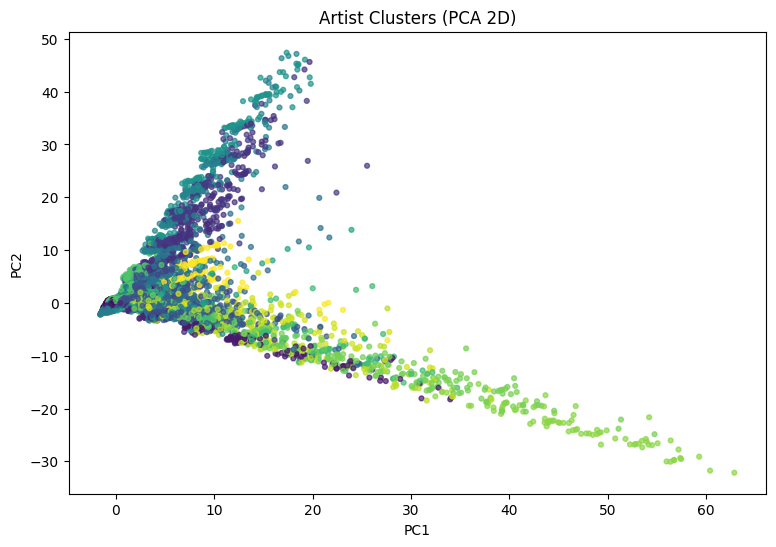

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# 2D PCA nur für Visualisierung
pca2 = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca2 = pca2.fit_transform(X_scaled)

plt.figure(figsize=(9, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=artist_df["cluster"].values, s=12, alpha=0.7)
plt.title("Artist Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Train: Album Popularity Regression (XGBoost)

Ziel: Vorhersage der **Album-Popularität** (0–100).

### Warum XGBoost statt Ridge?
- Nichtlineare Effekte (z.B. Release-Zeitpunkt, Track-Anzahl, Artist-Popularity) werden besser modelliert.
- Meist bessere MAE/RMSE als lineare Modelle.



In [57]:
Xtr, Xte, ytr, yte = train_test_split(
    X_album_pop, y_album_pop_clean, test_size=0.2, random_state=RANDOM_SEED
)

pre_album, _, _ = build_preprocessor_tree(X_album_pop)

xgb_album = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

pipe_album_pop = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_album),
    ("model", xgb_album),
])

pipe_album_pop.fit(Xtr, ytr)
pred = pipe_album_pop.predict(Xte)

album_pop_metrics = regression_report(yte, pred)
dump(pipe_album_pop, PATHS.models_dir / "03_album_popularity_pipeline_xgb.joblib")

['..\\data\\models\\baseline\\03_album_popularity_pipeline_xgb.joblib']


## Train: Mood Tags (Multi-Label)

Ziel: Mehrere Mood-Tags pro Track (z.B. happy, energetic, calm).

### Modellwahl (skalierbar)
Wir nutzen **One-vs-Rest** mit einem schnellen linearen Modell (SGDClassifier),
weil Multi-Label bedeutet:
- pro Label ein eigener Klassifikator
- sehr gut skalierbar auf große, sparse Feature-Matrizen



In [58]:


Xtr, Xte, Ytr, Yte = train_test_split(
    X_track_mood, Y_mood_clean,
    test_size=0.2, random_state=RANDOM_SEED
)

pre_mood, _, _ = build_preprocessor_linear(X_track_mood)

base_sgd = SGDClassifier(
    loss="log_loss",          # logistic
    alpha=1e-4,               # regularization (tune later)
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=RANDOM_SEED,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    shuffle=True
)

mood_model = OneVsRestClassifier(base_sgd, n_jobs=-1)

pipe_mood = Pipeline(steps=[
    ("sanitize", sanitize_tf),
    ("pre", pre_mood),
    ("model", mood_model),
])

pipe_mood.fit(Xtr, Ytr)

proba = pipe_mood.predict_proba(Xte)          # (n_samples, n_labels)
pred  = (proba >= 0.5).astype(int)            # threshold can be tuned per-label

mood_micro_f1 = float(f1_score(Yte, pred, average="micro"))
mood_macro_f1 = float(f1_score(Yte, pred, average="macro"))
per_label_f1  = {col: float(f1_score(Yte[col], pred[:, i])) for i, col in enumerate(Yte.columns)}

mood_metrics = {
    "micro_f1": mood_micro_f1,
    "macro_f1": mood_macro_f1,
    "per_label_f1": per_label_f1
}

dump(pipe_mood, PATHS.models_dir / "03_mood_pipeline.joblib")
mood_metrics


{'micro_f1': 0.29672029565039076,
 'macro_f1': 0.1861229880879021,
 'per_label_f1': {'energetic': 0.1025258180913276,
  'danceable': 0.016022431403965552,
  'acoustic': 0.40808724974251165,
  'instrumental': 0.18498200908393794,
  'happy': 0.188502236282317,
  'sad': 0.0002726838911991274,
  'chill': 0.40246848812005576}}

## `feature_config.json` speichern

An dieser Stelle exportieren wir die Datei **`feature_config.json`**.
Sie dient als **Scoring-Vertrag** zwischen Notebook 3 (Training) und Notebook 4 (Batch-Scoring).

### Warum diese Datei wichtig ist

Beim späteren Scoring (z. B. Millionen Datensätze) müssen **exakt dieselben Regeln** wie beim Training angewendet werden.
Die `feature_config.json` stellt **Reproduzierbarkeit und Konsistenz** sicher.

### Inhalt der `feature_config.json`

* **Feature-Listen**

  * numerische Features
  * kategoriale Features
  * Multi-Hot-Genre-Features

* **Genre-Encoding**

  * feste `top_genres`-Liste (gleiche Reihenfolge, gleiche Spalten)

* **Mood-Tags**

  * Schwellenwerte (z. B. Quantile für `valence`, `energy`)
  * Logik (`gt` / `lt`) und Tag-Namen

* **Hit-Label**

  * Parameter zur Hit-Definition (z. B. Perzentil)
  * sorgt für konsistente Zielerstellung

* **Metadaten (optional)**

  * Zeitstempel, Dataset-Version, Run-Infos


In [59]:
feature_config = {
    "run_meta": RUN_META,
    "top_genres": top_genres,
    "mood_thresholds": {str(k): v for k, v in mood_thresholds.items()},  # keys must be JSON-serializable
    "mood_tags": MOOD_TAGS,
    "track_features": {
        "numeric": TRACK_NUMERIC,
        "categorical": TRACK_CATEGORICAL,
        "genre_multi_hot_cols": list(track_genre_mh.columns),
    },
    "album_features": {
        "numeric": ALBUM_NUMERIC,
        "categorical": ALBUM_CATEGORICAL,
        "genre_multi_hot_cols": list(album_genre_mh.columns),
    },
    "artist_features": {
        "numeric_used_for_clustering": num_cols,
        "genre_multi_hot_cols": list(artist_genre_mh.columns),
        "kmeans_k": int(K_CLUSTERS),
    },
    "targets": {
        "hit_percentile_within_year": float(HIT_PERCENTILE),
        "hit_fallback_popularity_threshold": int(HIT_FALLBACK_POP_THRESHOLD),
    }
}

(PATHS.models_dir / "feature_config.json").write_text(json.dumps(feature_config, indent=2), encoding="utf-8")
print("Saved feature_config.json")


Saved feature_config.json


## Reports schreiben (JSON)

In diesem Schritt speichern wir die wichtigsten Ergebnisse aus Notebook 3 als **maschinenlesbare JSON-Reports**.

### Warum JSON-Reports?
Reine Notebook-Ausgaben sind nicht reproduzierbar.
JSON ermöglicht:

- Vergleich von Experimenten (Baseline vs. Tuning)
- Nachverfolgung von Verbesserungen über Zeit
- Nutzung in Dashboards oder CI-Pipelines
- Nachvollziehbarkeit für Notebook 4

### Was wird gespeichert?
- **Modell-Metriken** (Regression, Klassifikation, Mood, Clustering)
- **Dataset-Größen** (Tracks, Alben, Artists, Feature-Matrizen)

### Speicherort
Die Reports werden im Ordner **`reports/`** abgelegt
(z. B. `metrics_report.json`) und dienen als **zentrale Referenz** für diesen Run.


In [60]:
reports = {
    "track_popularity_regression": track_pop_metrics,
    "album_popularity_regression": album_pop_metrics,
    "hit_prediction": hit_metrics,
    "explicit_prediction": explicit_metrics,
    "mood_multilabel": mood_metrics,
    "artist_clustering": artist_cluster_artifact,
    "dataset_shapes": {
        "track_df": [int(track_df.shape[0]), int(track_df.shape[1])],
        "album_df": [int(album_df.shape[0]), int(album_df.shape[1])],
        "artist_df": [int(artist_df.shape[0]), int(artist_df.shape[1])],
        "X_track_pop": [int(X_track_pop.shape[0]), int(X_track_pop.shape[1])],
        "X_album_pop": [int(X_album_pop.shape[0]), int(X_album_pop.shape[1])],
    },
}

(PATHS.reports_dir / "metrics_report_xgb.json").write_text(json.dumps(reports, indent=2), encoding="utf-8")
print("Wrote metrics report:", PATHS.reports_dir / "metrics_report_xgb.json")


Wrote metrics report: ..\data\reports\03_target_and_features\metrics_report_xgb.json


## Speicher von Datasets

In [61]:
# =========================
# Datasets für Notebook 4 speichern
# =========================
DATA_DIR = Path("../data/datasets")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Track Popularity
X_track_pop.to_parquet(DATA_DIR / "X_track_pop.parquet", index=False)
pd.Series(y_track_pop_clean, name="track_popularity").to_frame().to_parquet(DATA_DIR / "y_track_pop.parquet", index=False)

# Album Popularity
X_album_pop.to_parquet(DATA_DIR / "X_album_pop.parquet", index=False)
pd.Series(y_album_pop_clean, name="album_popularity").to_frame().to_parquet(DATA_DIR / "y_album_pop.parquet", index=False)

# Hit Prediction
X_track_hit.to_parquet(DATA_DIR / "X_track_hit.parquet", index=False)
pd.Series(y_hit_clean, name="is_hit").to_frame().to_parquet(DATA_DIR / "y_hit.parquet", index=False)

# Explicit Prediction
X_track_explicit.to_parquet(DATA_DIR / "X_track_explicit.parquet", index=False)
pd.Series(y_explicit_clean, name="is_explicit").to_frame().to_parquet(DATA_DIR / "y_explicit.parquet", index=False)

# Mood Multi-Label (optional)
# Nur speichern, wenn du X_track_mood und Y_mood wirklich hast
X_track_mood.to_parquet(DATA_DIR / "X_track_mood.parquet", index=False)
# Y_mood ist meistens ein DataFrame mit mehreren Label-Spalten
Y_mood_clean.to_parquet(DATA_DIR / "Y_mood.parquet", index=False)

print("Datasets gespeichert in:", DATA_DIR.resolve())


Datasets gespeichert in: C:\GitHub\data-science\uni-course\spotify-data-project\data\datasets
